## Genetic

In [37]:
import random
from PIL import Image, ImageDraw
import numpy as np
import random
import cv2
import copy
import math
import matplotlib.pyplot as plt

In [38]:

OFFSET = 10


def generate_point(width, height):
    x = random.randrange(0 - OFFSET, width + OFFSET, 1)
    y = random.randrange(0 - OFFSET, height + OFFSET, 1)
    return (x, y)

class Triangle:
    def __init__(self, img_width, img_height):
        self.points = []
        for i in range(3):
            self.points.append(generate_point(img_width,img_height))
        
        self.channel1 = random.randint(0, 255)
        self.channel2 = random.randint(0, 255)
        self.channel3 = random.randint(0, 255)
        self.channel4 = random.randint(0, 255)
        self.color = (
            self.channel1,
            self.channel2,
            self.channel3, 
            self.channel4)

        self._img_width = img_width
        self._img_height = img_height


    def mutate_points(self):
        index = random.randint(0, 2)
        self.points[index] = generate_point(self._img_width, self._img_height)

    def mutate_color(self):
        colors = list(self.color)
        point = random.randint(0,3)
        colors[point] = random.randint(0, 255)
        self.color = tuple(colors)



In [39]:
class Chromosome:  
    def __init__(self,img_height, img_width,target_image,num_triangles):
        self.img_height = img_height
        self.img_width = img_width  
        self.background_color = (0,0,0,255)
        self.triangles = [Triangle(img_width, img_height) for i in range(num_triangles)]
        self.target_image = target_image
        self.num_trinagles = num_triangles
        self.fit = -math.inf
        
    def mutate(self):
        # pm = 0.3
        # for i in range(self.num_trinagles):
        #     p = random.random()
        #     if(p <= pm):
        triangle = random.choice(self.triangles)
        self.fit = -math.inf
        choice = random.randint(0, 1)
        if(choice == 0):
            triangle.mutate_points()
        elif(choice == 1):
            triangle.mutate_color()
    
    def draw(self) -> Image:
        size = self.target_image.size
        img = Image.new('RGB', size, self.background_color)
        draw = Image.new('RGBA', size)
        pdraw = ImageDraw.Draw(draw)
        for triangle in self.triangles:
            colour = triangle.color
            points = triangle.points
            pdraw.polygon(points, fill=colour, outline=colour)
            img.paste(draw, mask=draw)
        return img
        

    def fitness(self) -> float:
        created_image = np.array(self.draw())
        target = np.array(self.target_image)
        fitness = np.sum(((created_image/255 - target/255)**2))
        self.fit = 0 - fitness
        return self.fit

In [40]:
class GeneticAlgorithm():
    def __init__(self,max_width,max_height,target_image, population_size, triangles_number):
        self.population_size = population_size
        self.max_width = max_width
        self.max_height = max_height
        self.population = [Chromosome(max_height,max_width,target_image, triangles_number) for i in range(population_size)]
        self.target_image = target_image
    
    def calc_fitnesses(self):
        fitnesses = []
        for chromosome in self.population:  
            fitnesses.append(chromosome.fitness())
        return fitnesses
    
    def sort_population(self, fitnesses):
        return [x for _, x in sorted(zip(fitnesses, self.population), key=lambda pair: pair[0], reverse = True)]
    
    
    def cross_over(self):
        random.shuffle(self.population)
        pc = 0.8
        i = 0
        while(i < len(self.population)):
            p = random.random()
            if p <= pc:
                n = random.randrange(0, (self.population[i].num_trinagles - 1))
                child1 = self.population[i].triangles[:n] + self.population[i+1].triangles[n:]
                child2 = self.population[i+1].triangles[:n] + self.population[i].triangles[n:]
                self.population[i].triangles = child1
                self.population[i+1].triangles = child2
                
            self.population[i].fit = -math.inf
            self.population[i + 1].fit = -math.inf
            # self.population[i].mutate()
            # self.population[i+1].mutate()
            i += 2
            
    def cross_over2(self):
        random.shuffle(self.population)
        pc = 0.8
        i = 0
        while(i < len(self.population)):
            p = random.random()
            if p <= pc:
                n1 = random.randrange(1, self.population[i].num_trinagles - 4)
                n2 = random.randrange(n1, self.population[i].num_trinagles - 2)
                child1 = self.population[i].triangles[:n1] + self.population[i+1].triangles[n1:n2] + self.population[i].triangles[n2:]
                child2 = self.population[i+1].triangles[:n1] + self.population[i].triangles[n1:n2] + self.population[i+1].triangles[n2:]
                self.population[i].triangles = child1
                self.population[i+1].triangles = child2
            i += 2

    def mutation(self):  
        pm = 0.2
        for chromosome in self.population:
            p = random.random()
            if(p < pm):
                chromosome.mutate()
    
    def run(self,n_generations):
        for iteration in range(n_generations):
            fitnesses = self.calc_fitnesses()
            sorted_population = self.sort_population(fitnesses)
            elite_population = copy.deepcopy(sorted_population[:int(0.3*self.population_size)])
            # sorted_cross_population = self.sort_population(fitnesses)
            # self.population = elite_population + sorted_cross_population[:int(0.7*self.population_size)]
            if iteration % 10 == 0:
                #this part shows the log for fitness
                fit_arr = np.array(fitnesses)
                print(f"Fitness in Generation {iteration}: mean: {np.mean(fit_arr)}, max: {np.max(fit_arr)} min: {np.min(fit_arr)}")
                if iteration % 100 == 0:
                    self.get_best_of_population()
                    #self.show_best_individual()
            
            self.cross_over()
            self.mutation()
            fitnesses = self.calc_fitnesses()
            sorted_cross_population = self.sort_population(fitnesses)
            self.population = elite_population + sorted_cross_population[:int(0.7*self.population_size)]
            # apply mutation and cross over and implement your method to select next generation chromosomes    
    def get_best_of_population(self):
        fitnesses = self.calc_fitnesses()
        sorted_population = [x for _, x in sorted(zip(fitnesses, self.population), key=lambda pair: pair[0])]
        best_population = sorted_population[-1]
        image = best_population.draw()
        # cv2.imshow("Reconstructed Image", np.array(image))
        # cv2.waitKey(0)
        # cv2.destroyAllWindows()
        plt.imshow(image)
        plt.axis('off')
        plt.show()
        
    def show_best_individual(self):
        best_chromosome = max(self.population, key=lambda chromo: chromo.fitness())
        best_image = best_chromosome.draw()
        plt.imshow(best_image)
        plt.axis('off')
        plt.show()

In [41]:
def resize(image,max_size):
    new_width = int((max_size/max(image.size[0],image.size[1]))* image.size[0])
    new_height = int((max_size/max(image.size[0],image.size[1]))* image.size[1])
    image = image.resize((new_width,new_height), resample=Image.Resampling.LANCZOS)  
    return image

Fitness in Generation 0: mean: -3669.881426528259, max: -2580.8181622452903 min: -4804.4776316801235


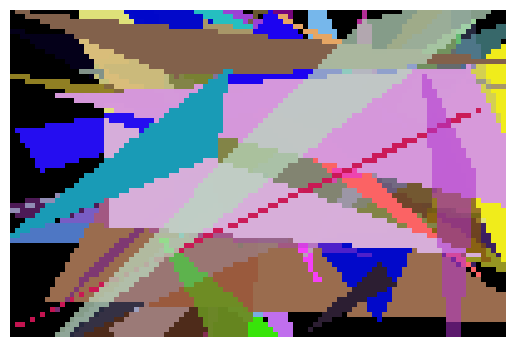

Fitness in Generation 10: mean: -2381.634930257593, max: -2153.105420991926 min: -2498.122306805075
Fitness in Generation 20: mean: -1972.6215041906958, max: -1867.6188542868126 min: -2048.5143867743172
Fitness in Generation 30: mean: -1664.8536190695888, max: -1549.3559554017686 min: -1751.8943483275664
Fitness in Generation 40: mean: -1527.076128104575, max: -1459.1823760092273 min: -1545.7213687043445
Fitness in Generation 50: mean: -1411.280396462899, max: -1340.2335870818915 min: -1436.4303267973858
Fitness in Generation 60: mean: -1280.3107920030757, max: -1247.6986543637063 min: -1307.1097424067666
Fitness in Generation 70: mean: -1181.0619909265668, max: -1152.2708496732025 min: -1199.3710265282587
Fitness in Generation 80: mean: -1124.6048393694732, max: -1103.5014071510957 min: -1136.7641368704344
Fitness in Generation 90: mean: -1073.8484453671665, max: -1048.7143867743175 min: -1082.3778239138792
Fitness in Generation 100: mean: -1032.7505753171856, max: -1018.1134948096886

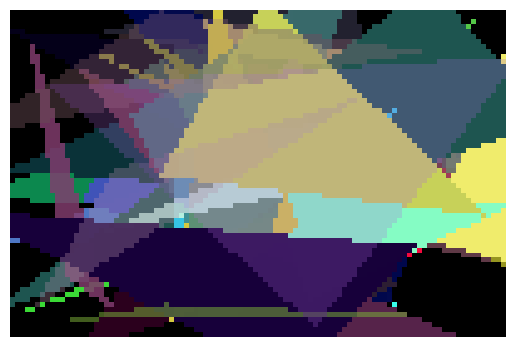

Fitness in Generation 110: mean: -998.4059300269129, max: -959.1088965782392 min: -1012.44399846213
Fitness in Generation 120: mean: -940.4276009227219, max: -931.3983544790465 min: -952.8846751249521
Fitness in Generation 130: mean: -912.9357078046904, max: -897.2162091503269 min: -919.3781314878892
Fitness in Generation 140: mean: -887.7443338715879, max: -873.0941484044598 min: -893.8131641676279
Fitness in Generation 150: mean: -865.9188718185313, max: -829.5770396001537 min: -871.2495963091119
Fitness in Generation 160: mean: -825.8299487889273, max: -820.7026220684352 min: -828.3811303344868
Fitness in Generation 170: mean: -805.7276773548635, max: -788.8498731257209 min: -812.5013763936947
Fitness in Generation 180: mean: -775.539906497501, max: -764.4437370242214 min: -783.3041599384851
Fitness in Generation 190: mean: -748.8534877354863, max: -743.8705267204921 min: -752.8638216070742
Fitness in Generation 200: mean: -716.6705673202615, max: -695.3151710880431 min: -740.447843

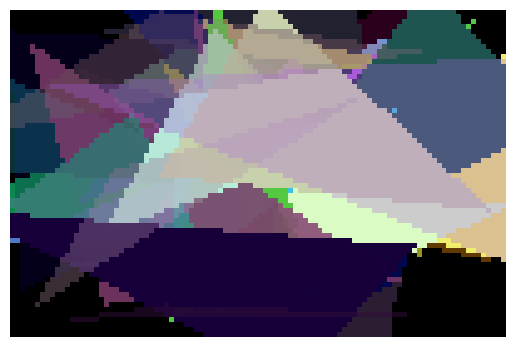

Fitness in Generation 210: mean: -686.5151046520567, max: -674.3156478277585 min: -690.7359323337178
Fitness in Generation 220: mean: -655.2866998846596, max: -648.8588081507112 min: -659.9276278354479
Fitness in Generation 230: mean: -641.2934525182623, max: -630.1928027681662 min: -643.0018915801614
Fitness in Generation 240: mean: -620.5458746635909, max: -616.4593002691273 min: -623.3988465974626
Fitness in Generation 250: mean: -612.9030417531718, max: -608.9717800845829 min: -614.8256209150327
Fitness in Generation 260: mean: -593.0530831218762, max: -586.9522337562477 min: -597.803475586313
Fitness in Generation 270: mean: -583.2516767397154, max: -578.95846212995 min: -585.4998077662437
Fitness in Generation 280: mean: -567.8252565936178, max: -558.5816993464051 min: -570.8589158016148
Fitness in Generation 290: mean: -552.3779981545559, max: -547.1572779700116 min: -555.599169550173
Fitness in Generation 300: mean: -534.8528484429066, max: -527.8609457900807 min: -542.97530180

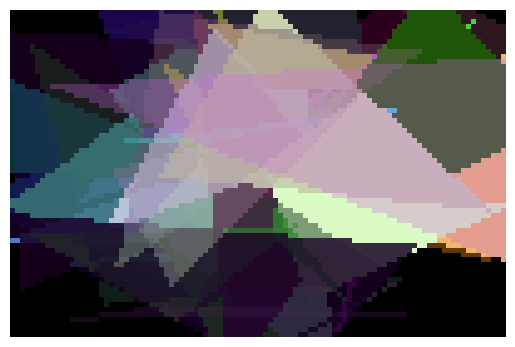

Fitness in Generation 310: mean: -521.8014669742407, max: -518.7542022299116 min: -523.1473587081892
Fitness in Generation 320: mean: -515.3679672433678, max: -510.8134871203383 min: -516.5549096501345
Fitness in Generation 330: mean: -506.08044521337945, max: -498.61591695501727 min: -507.6322645136486
Fitness in Generation 340: mean: -494.73442722030006, max: -490.10465205690116 min: -497.1036216839677
Fitness in Generation 350: mean: -485.68561568627456, max: -480.8748173779316 min: -487.2306189926951
Fitness in Generation 360: mean: -478.17196493656286, max: -476.73074971164937 min: -479.0858285274894
Fitness in Generation 370: mean: -469.17297393310275, max: -466.66134563629373 min: -471.2273125720876
Fitness in Generation 380: mean: -464.1365525567089, max: -461.5455286428296 min: -464.78060745866975
Fitness in Generation 390: mean: -457.1644521337946, max: -453.27231064975007 min: -459.4246212995002
Fitness in Generation 400: mean: -446.59497900807395, max: -436.76587466359086 m

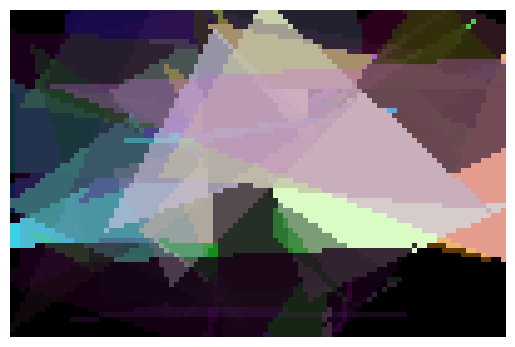

Fitness in Generation 410: mean: -434.49390941945404, max: -432.98271434063815 min: -436.1241676278355
Fitness in Generation 420: mean: -431.0959737024222, max: -426.9752556708958 min: -431.9295347943099
Fitness in Generation 430: mean: -425.4113607074203, max: -422.9641676278354 min: -426.3824529027297
Fitness in Generation 440: mean: -417.72091272587465, max: -408.10292964244525 min: -422.24522875816996
Fitness in Generation 450: mean: -401.93966751249513, max: -395.0576547481737 min: -404.3844059976932
Fitness in Generation 460: mean: -391.0706328335256, max: -386.77113417916183 min: -393.7397770088427
Fitness in Generation 470: mean: -383.0041297962323, max: -381.25605536332176 min: -383.7412995001922
Fitness in Generation 480: mean: -378.19890088427513, max: -376.3787773933102 min: -379.3823298731257
Fitness in Generation 490: mean: -373.6112898116109, max: -371.5254133025759 min: -375.0678969627066
Fitness in Generation 500: mean: -368.75703037293334, max: -367.46380622837364 min

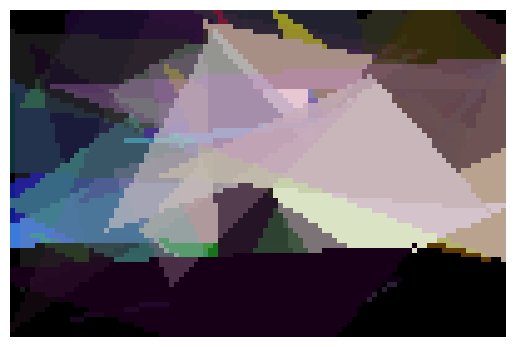

Fitness in Generation 510: mean: -363.9919630911188, max: -358.04904267589393 min: -366.601783929258
Fitness in Generation 520: mean: -357.3520582852749, max: -356.4434602076125 min: -357.5919108035371
Fitness in Generation 530: mean: -355.3202237600923, max: -351.4282352941176 min: -356.39074202229915
Fitness in Generation 540: mean: -349.2568550557478, max: -346.8529027297193 min: -350.0138254517493
Fitness in Generation 550: mean: -345.1360718185313, max: -343.3355324875048 min: -346.2129642445213
Fitness in Generation 560: mean: -341.51678216070746, max: -338.72813533256436 min: -341.84879661668583
Fitness in Generation 570: mean: -338.03888765859296, max: -335.19864667435604 min: -338.6210688196847
Fitness in Generation 580: mean: -333.80487520184545, max: -333.001107266436 min: -334.7277508650519
Fitness in Generation 590: mean: -331.1980063052672, max: -329.93714725105735 min: -331.9837293348712
Fitness in Generation 600: mean: -328.42546805074977, max: -325.959938485198 min: -3

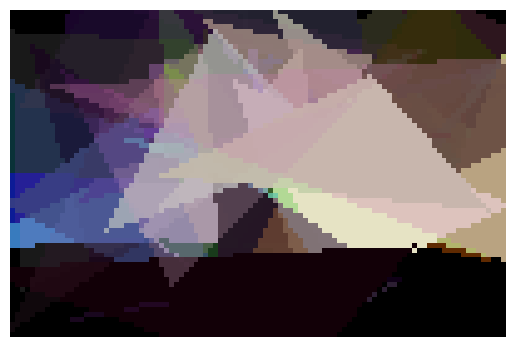

Fitness in Generation 610: mean: -322.7066655901576, max: -320.94765090349864 min: -324.31966166858905
Fitness in Generation 620: mean: -320.13574240676667, max: -318.5694732795079 min: -320.81500961168774
Fitness in Generation 630: mean: -317.17718985005763, max: -312.64167627835445 min: -318.25236447520183
Fitness in Generation 640: mean: -312.093321030373, max: -310.996739715494 min: -312.64167627835445
Fitness in Generation 650: mean: -310.4820567474048, max: -309.6293271818531 min: -310.8654978854287
Fitness in Generation 660: mean: -308.76150480584386, max: -305.17259515570936 min: -309.41782391387926
Fitness in Generation 670: mean: -304.5282085351788, max: -303.47474048442905 min: -304.90843521722417
Fitness in Generation 680: mean: -302.70609088811995, max: -300.6904113802384 min: -303.4493041138024
Fitness in Generation 690: mean: -299.25667158785075, max: -296.58495963091116 min: -300.4963475586313
Fitness in Generation 700: mean: -296.17263052672047, max: -295.6313264129181

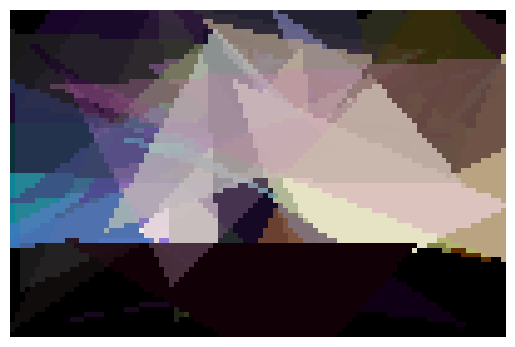

Fitness in Generation 710: mean: -294.8476109188774, max: -292.8961476355248 min: -295.27807766243757
Fitness in Generation 720: mean: -290.12170211457135, max: -288.5696578239138 min: -290.7957708573625
Fitness in Generation 730: mean: -287.06761061130334, max: -285.65671664744326 min: -287.82211457131865
Fitness in Generation 740: mean: -284.77452964244515, max: -283.8603460207612 min: -285.1264436755094
Fitness in Generation 750: mean: -283.1330242214532, max: -281.85842368319874 min: -283.8603460207612
Fitness in Generation 760: mean: -281.4814840445982, max: -280.86334486735865 min: -281.7810380622837
Fitness in Generation 770: mean: -280.13476047673964, max: -277.41036524413687 min: -280.86339100346015
Fitness in Generation 780: mean: -276.8443826220684, max: -275.75838523644745 min: -277.1810995770857
Fitness in Generation 790: mean: -274.72225067281806, max: -274.1647827758554 min: -274.9821760861207
Fitness in Generation 800: mean: -273.4782783544791, max: -272.9695347943098 m

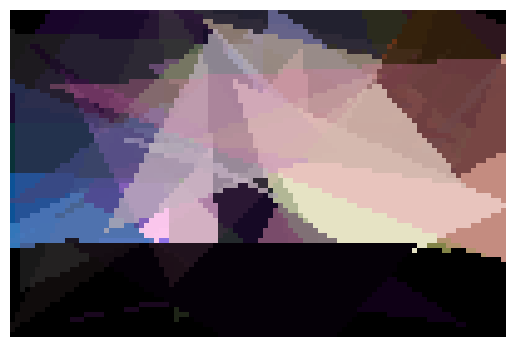

Fitness in Generation 810: mean: -272.2556366013072, max: -271.7819454056132 min: -272.46437524029216
Fitness in Generation 820: mean: -271.0673866974241, max: -270.2430603613994 min: -271.4724490580546
Fitness in Generation 830: mean: -269.86002475970776, max: -269.4152864282968 min: -270.0227450980392
Fitness in Generation 840: mean: -268.8917497885428, max: -267.8623606305267 min: -269.2741253364091
Fitness in Generation 850: mean: -266.39587558631297, max: -265.57974625144175 min: -267.32555171088035
Fitness in Generation 860: mean: -264.9061740868897, max: -264.38429834678965 min: -265.18886582083815
Fitness in Generation 870: mean: -264.0833810073048, max: -263.2483813917724 min: -264.3521261053441
Fitness in Generation 880: mean: -263.17196785851587, max: -263.02788158400614 min: -263.2483813917724
Fitness in Generation 890: mean: -262.8012675124952, max: -262.6544559784698 min: -262.8708035371011
Fitness in Generation 900: mean: -261.11698008458285, max: -261.040984236832 min: 

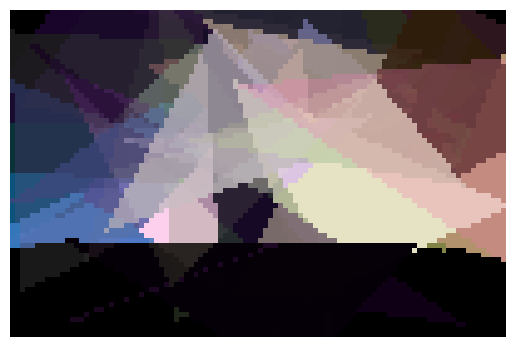

Fitness in Generation 910: mean: -259.9821588619762, max: -258.8878738946559 min: -260.8941330257593
Fitness in Generation 920: mean: -258.6050091503268, max: -258.18522106881966 min: -258.7911726259131
Fitness in Generation 930: mean: -258.0819632449058, max: -257.31709342560555 min: -258.18522106881966
Fitness in Generation 940: mean: -256.5632499807767, max: -256.0260515186466 min: -256.6476585928489
Fitness in Generation 950: mean: -255.9405344098423, max: -255.15457131872358 min: -256.0260515186466
Fitness in Generation 960: mean: -255.0669291810842, max: -254.97337946943483 min: -255.15457131872358
Fitness in Generation 970: mean: -254.05931872356786, max: -253.10788158400612 min: -254.92915032679738
Fitness in Generation 980: mean: -253.09626574394454, max: -252.97005767012692 min: -253.10788158400612
Fitness in Generation 990: mean: -252.88311710880424, max: -252.66169934640524 min: -252.97005767012692
Fitness in Generation 1000: mean: -250.95663929257978, max: -249.98745098039

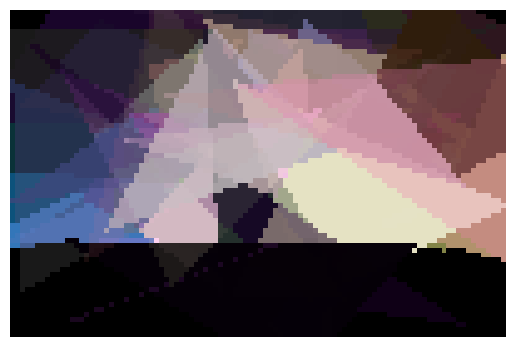

Fitness in Generation 1010: mean: -249.4796213763937, max: -248.61133410226836 min: -249.94951172625912
Fitness in Generation 1020: mean: -248.55039907727794, max: -248.14797385620918 min: -248.64581314878893
Fitness in Generation 1030: mean: -247.93537224144563, max: -247.4337101114956 min: -248.04469050365248
Fitness in Generation 1040: mean: -247.1952670511341, max: -246.94620530565166 min: -247.43397154940408
Fitness in Generation 1050: mean: -246.68290965013458, max: -246.54788158400615 min: -246.75121876201462
Fitness in Generation 1060: mean: -246.38129980776623, max: -246.1851287966167 min: -246.5013456362937
Fitness in Generation 1070: mean: -245.91930934256052, max: -245.72813533256442 min: -246.05940792003074
Fitness in Generation 1080: mean: -245.70549757785463, max: -245.12956555171084 min: -245.72813533256442
Fitness in Generation 1090: mean: -245.06362322183782, max: -244.76253748558247 min: -245.14013071895423
Fitness in Generation 1100: mean: -244.4881903883122, max: -

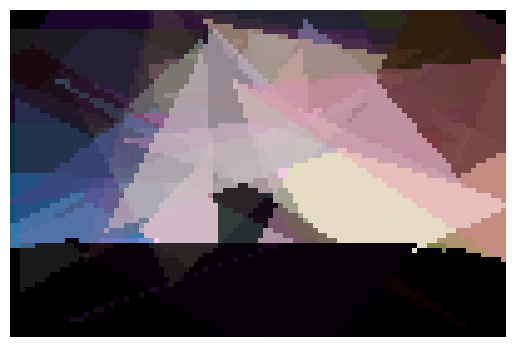

Fitness in Generation 1110: mean: -243.42927720107656, max: -243.18880430603613 min: -243.8637908496732
Fitness in Generation 1120: mean: -242.83938500576699, max: -242.34111495578625 min: -243.0487812379854
Fitness in Generation 1130: mean: -241.87421407151095, max: -241.61088811995384 min: -242.24235294117645
Fitness in Generation 1140: mean: -240.9664261437908, max: -238.97970011534025 min: -241.2143637062668
Fitness in Generation 1150: mean: -238.64371626297586, max: -238.03973856209151 min: -238.83235678585157
Fitness in Generation 1160: mean: -237.07554648212226, max: -236.91723183391002 min: -237.78336024605923
Fitness in Generation 1170: mean: -235.7554039215686, max: -235.68073817762397 min: -235.80555171088042
Fitness in Generation 1180: mean: -235.63171687812374, max: -235.55875432525954 min: -235.67858515955402
Fitness in Generation 1190: mean: -235.46516216839683, max: -235.31889273356404 min: -235.5296270665129
Fitness in Generation 1200: mean: -235.21117493271817, max: -

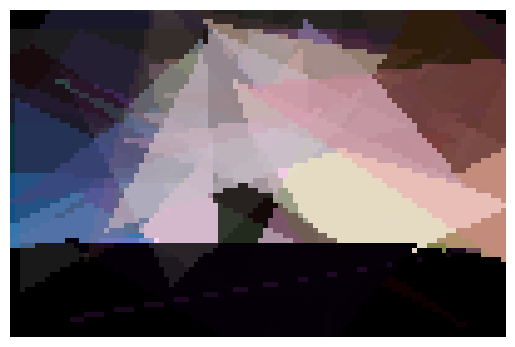

Fitness in Generation 1210: mean: -234.7121344098423, max: -234.56044598231446 min: -234.85099577085734
Fitness in Generation 1220: mean: -234.41520123029605, max: -234.20492118415996 min: -234.52121491733948
Fitness in Generation 1230: mean: -233.92781130334487, max: -233.679907727797 min: -234.10062283737025
Fitness in Generation 1240: mean: -232.69592356785853, max: -231.66921953094968 min: -233.51738562091504
Fitness in Generation 1250: mean: -231.3875663206459, max: -229.6350788158401 min: -231.6643598615917
Fitness in Generation 1260: mean: -229.1985968473665, max: -228.95801614763556 min: -229.38086889657825
Fitness in Generation 1270: mean: -228.3918828143022, max: -228.02196078431373 min: -228.68135332564398
Fitness in Generation 1280: mean: -227.9411763168012, max: -227.7380084582853 min: -228.02196078431373
Fitness in Generation 1290: mean: -227.62942821991544, max: -227.46763552479817 min: -227.69822376009228
Fitness in Generation 1300: mean: -227.27387743175706, max: -227.

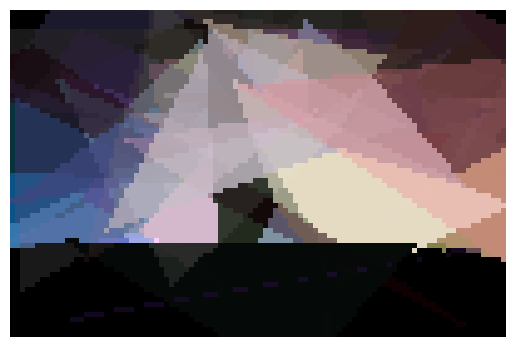

Fitness in Generation 1310: mean: -227.0372664359862, max: -226.963721645521 min: -227.08436755094198
Fitness in Generation 1320: mean: -226.50930841983853, max: -226.27792387543255 min: -226.93344098423685
Fitness in Generation 1330: mean: -225.42172795078815, max: -225.24807381776242 min: -225.59069588619764
Fitness in Generation 1340: mean: -225.10045290272973, max: -225.02053056516726 min: -225.19973856209154
Fitness in Generation 1350: mean: -224.98765536332184, max: -224.94526720492118 min: -225.02053056516726
Fitness in Generation 1360: mean: -224.51218054594383, max: -222.3104805843906 min: -224.94168396770473
Fitness in Generation 1370: mean: -222.01254717416379, max: -221.71351018838908 min: -222.15643214148406
Fitness in Generation 1380: mean: -221.64569104190693, max: -221.47347943098808 min: -221.70340638216072
Fitness in Generation 1390: mean: -221.1296198385236, max: -220.10448289119572 min: -221.45142637447137
Fitness in Generation 1400: mean: -220.08735071126495, max: 

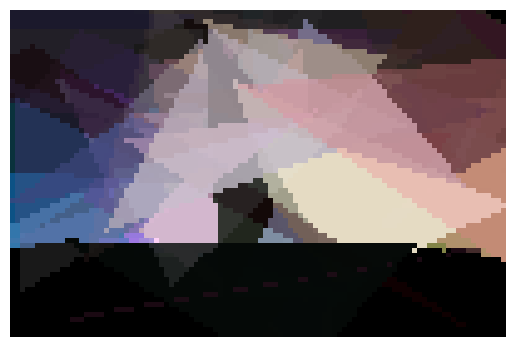

Fitness in Generation 1410: mean: -219.91442537485582, max: -218.71681660899654 min: -220.06818915801617
Fitness in Generation 1420: mean: -218.488613917724, max: -218.44219915417145 min: -218.51360246059207
Fitness in Generation 1430: mean: -218.32307881584006, max: -218.17511726259133 min: -218.37976163014227
Fitness in Generation 1440: mean: -218.0348811995386, max: -218.00552095347945 min: -218.079846212995
Fitness in Generation 1450: mean: -217.90561430219154, max: -217.78096116878123 min: -218.00552095347945
Fitness in Generation 1460: mean: -217.39220346020767, max: -216.93596309111885 min: -217.72009227220303
Fitness in Generation 1470: mean: -216.86674094579018, max: -216.7142945021146 min: -216.93596309111885
Fitness in Generation 1480: mean: -216.582490734333, max: -216.44668973471744 min: -216.63177239523262
Fitness in Generation 1490: mean: -216.35603936947325, max: -216.17368704344483 min: -216.36421376393696
Fitness in Generation 1500: mean: -216.12709773164167, max: -21

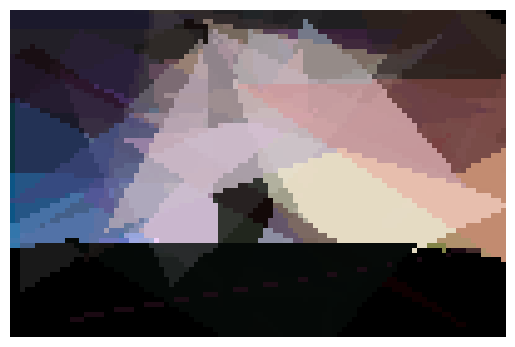

Fitness in Generation 1510: mean: -215.9558296039985, max: -215.6956247597078 min: -216.02768166089965
Fitness in Generation 1520: mean: -215.52038785082655, max: -215.34357554786618 min: -215.58737408688967
Fitness in Generation 1530: mean: -214.76926551326417, max: -214.49737793156478 min: -215.34357554786618
Fitness in Generation 1540: mean: -214.47960722798928, max: -214.27813917723952 min: -214.49737793156478
Fitness in Generation 1550: mean: -213.8145336409073, max: -213.62182237600922 min: -214.0301730103806
Fitness in Generation 1560: mean: -213.58828665897727, max: -213.5347635524798 min: -213.59921568627453
Fitness in Generation 1570: mean: -213.4812458285275, max: -213.41759323337178 min: -213.5023913879277
Fitness in Generation 1580: mean: -213.21294978854286, max: -212.9748865820838 min: -213.39012687427913
Fitness in Generation 1590: mean: -212.88410119184925, max: -212.7705036524414 min: -212.9513879277201
Fitness in Generation 1600: mean: -212.72049519415611, max: -212.

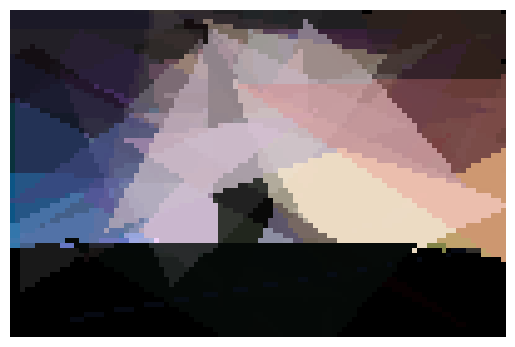

Fitness in Generation 1610: mean: -212.51037493271818, max: -212.46925028835062 min: -212.58905036524413
Fitness in Generation 1620: mean: -210.53273710111495, max: -210.38909650134568 min: -210.6182391387928
Fitness in Generation 1630: mean: -210.20521322568237, max: -210.1841291810842 min: -210.25645520953483
Fitness in Generation 1640: mean: -210.1344759707805, max: -210.00139946174548 min: -210.16210688196847
Fitness in Generation 1650: mean: -209.97045920799687, max: -209.92224529027297 min: -210.00187620146096
Fitness in Generation 1660: mean: -209.74874617454827, max: -209.49988465974627 min: -209.92224529027297
Fitness in Generation 1670: mean: -209.3835052672049, max: -208.83641676278356 min: -209.49960784313726
Fitness in Generation 1680: mean: -208.8135787773934, max: -208.7820222991157 min: -208.84550557477894
Fitness in Generation 1690: mean: -208.7435372549019, max: -208.64247597078048 min: -208.77185697808534
Fitness in Generation 1700: mean: -208.54022314494424, max: -2

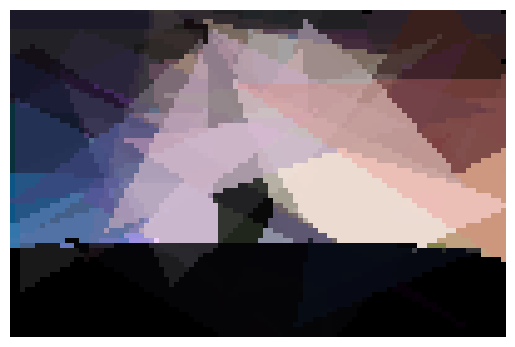

Fitness in Generation 1710: mean: -208.0918940407536, max: -207.98023836985772 min: -208.33251826220686
Fitness in Generation 1720: mean: -207.63471157247213, max: -207.52175317185694 min: -207.74892733564013
Fitness in Generation 1730: mean: -207.4695952326027, max: -207.45174932718186 min: -207.52175317185694
Fitness in Generation 1740: mean: -207.39869065743943, max: -207.22754325259518 min: -207.45174932718186
Fitness in Generation 1750: mean: -206.8844347558631, max: -205.92524413687045 min: -207.20478277585545
Fitness in Generation 1760: mean: -204.94915863129566, max: -204.6964552095348 min: -205.8553479430988
Fitness in Generation 1770: mean: -204.40878938869662, max: -204.12875048058436 min: -204.6964552095348
Fitness in Generation 1780: mean: -204.10026728181464, max: -204.03106497500963 min: -204.13151864667435
Fitness in Generation 1790: mean: -203.92174871203383, max: -203.82951172625914 min: -204.00409073433292
Fitness in Generation 1800: mean: -203.49017485582465, max: -

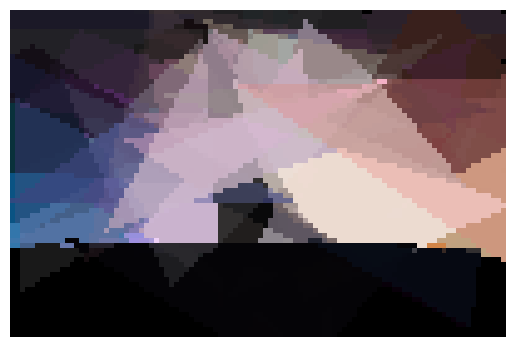

Fitness in Generation 1810: mean: -200.71957708573632, max: -186.61920799692425 min: -203.37840830449824
Fitness in Generation 1820: mean: -186.59874786620534, max: -185.760768935025 min: -187.31221837754708
Fitness in Generation 1830: mean: -185.74183175701663, max: -185.31454056132256 min: -185.760768935025
Fitness in Generation 1840: mean: -185.28300776624374, max: -185.21757785467125 min: -185.30632833525564
Fitness in Generation 1850: mean: -184.64102237600923, max: -184.17234909650134 min: -184.83312572087658
Fitness in Generation 1860: mean: -184.14692103037302, max: -184.03560169165704 min: -184.1836216839677
Fitness in Generation 1870: mean: -183.8072064590542, max: -183.61294886582084 min: -183.8701422529796
Fitness in Generation 1880: mean: -183.45145743944641, max: -183.12619761630143 min: -183.56608996539794
Fitness in Generation 1890: mean: -183.02343237216454, max: -181.8091503267974 min: -183.08621299500194
Fitness in Generation 1900: mean: -181.808736947328, max: -181.

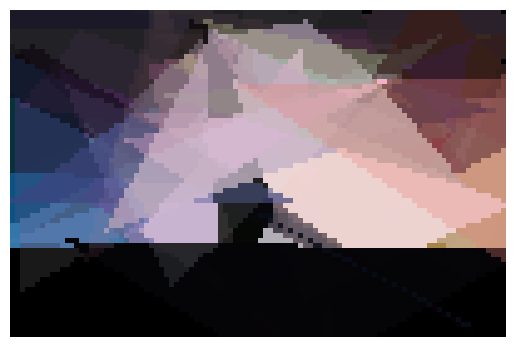

Fitness in Generation 1910: mean: -181.45851441753177, max: -181.21079584775086 min: -181.65213379469438
Fitness in Generation 1920: mean: -180.80801122645136, max: -180.56793540945787 min: -181.07896962706653
Fitness in Generation 1930: mean: -180.39729442522108, max: -180.18825067281816 min: -180.51554017685504
Fitness in Generation 1940: mean: -179.99857777777777, max: -179.7771164936563 min: -180.16725874663592
Fitness in Generation 1950: mean: -179.48476216839677, max: -179.10908112264514 min: -179.65805459438678
Fitness in Generation 1960: mean: -179.1066948096886, max: -179.08113802383696 min: -179.1407458669742
Fitness in Generation 1970: mean: -179.05738685121105, max: -178.93702422145327 min: -179.08113802383696
Fitness in Generation 1980: mean: -178.76770042291432, max: -178.59860053825452 min: -178.85159554017685
Fitness in Generation 1990: mean: -178.52377270280655, max: -177.9829142637447 min: -178.59341791618607
Fitness in Generation 2000: mean: -177.84465590157637, max:

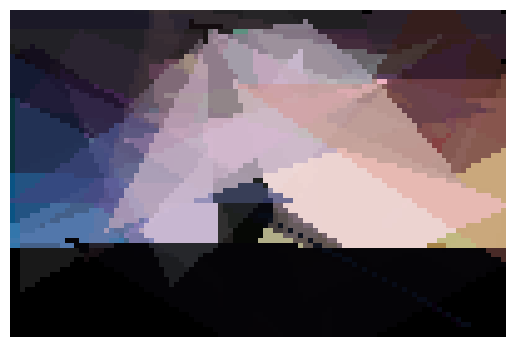

Fitness in Generation 2010: mean: -177.53093533256444, max: -176.74037677816227 min: -177.68310649750097
Fitness in Generation 2020: mean: -176.62429219530952, max: -176.53662437524028 min: -176.65062668204536
Fitness in Generation 2030: mean: -176.52342037677815, max: -176.50932718185314 min: -176.53662437524028
Fitness in Generation 2040: mean: -176.3108013840831, max: -175.8378623606305 min: -176.50019223375625
Fitness in Generation 2050: mean: -175.66155878508263, max: -175.07758554402147 min: -175.8246674356017
Fitness in Generation 2060: mean: -174.79741099577092, max: -174.45834678969624 min: -174.9673356401384
Fitness in Generation 2070: mean: -174.10962660515187, max: -173.7579546328335 min: -174.3532026143791
Fitness in Generation 2080: mean: -173.66001553248753, max: -173.49477893118035 min: -173.7579546328335
Fitness in Generation 2090: mean: -173.28383144944252, max: -173.02094579008073 min: -173.4325105728566
Fitness in Generation 2100: mean: -172.8561496347558, max: -172

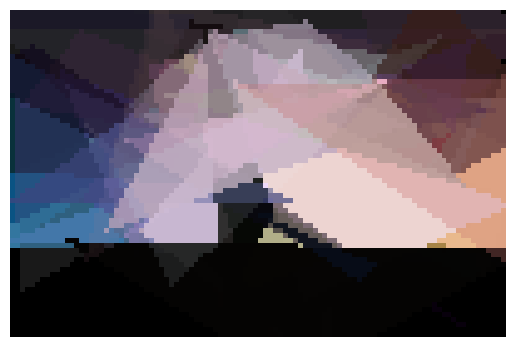

Fitness in Generation 2110: mean: -172.43039784698186, max: -172.3745174932718 min: -172.47349480968856
Fitness in Generation 2120: mean: -172.28184713571696, max: -171.99841599384854 min: -172.3745174932718
Fitness in Generation 2130: mean: -171.96478062283728, max: -171.82792772010765 min: -171.98874279123413
Fitness in Generation 2140: mean: -171.60758569780853, max: -163.17923875432524 min: -171.82792772010765
Fitness in Generation 2150: mean: -163.0957833141099, max: -162.64498269896194 min: -163.13193387158785
Fitness in Generation 2160: mean: -162.53375809304111, max: -162.08353710111498 min: -162.61004229142637
Fitness in Generation 2170: mean: -161.76178715878504, max: -161.62683583237217 min: -161.82320645905418
Fitness in Generation 2180: mean: -161.30856578239138, max: -160.94725105728565 min: -161.45971549404075
Fitness in Generation 2190: mean: -160.3449004229143, max: -159.87198769703963 min: -160.62792772010766
Fitness in Generation 2200: mean: -159.81519523260283, max:

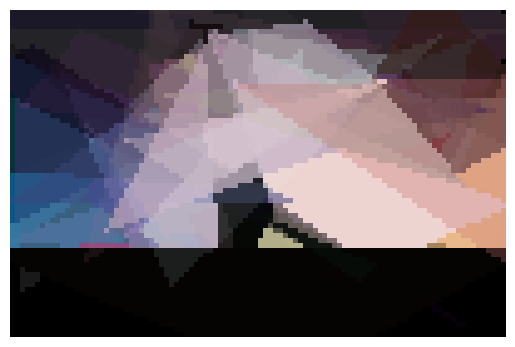

Fitness in Generation 2210: mean: -159.47980376778168, max: -159.26477508650518 min: -159.49364090734332
Fitness in Generation 2220: mean: -158.93039523260285, max: -158.51077277970012 min: -159.2062437524029
Fitness in Generation 2230: mean: -158.50452702806615, max: -158.45430219146482 min: -158.51077277970012
Fitness in Generation 2240: mean: -158.2029079584775, max: -157.8627912341407 min: -158.45153402537485
Fitness in Generation 2250: mean: -157.3571892349096, max: -157.0321568627451 min: -157.5364244521338
Fitness in Generation 2260: mean: -156.98287351018837, max: -156.8875970780469 min: -157.0321568627451
Fitness in Generation 2270: mean: -156.58415624759706, max: -156.45959246443672 min: -156.69136485966936
Fitness in Generation 2280: mean: -156.38822376009227, max: -156.2396770472895 min: -156.45905420991923
Fitness in Generation 2290: mean: -156.0810712802768, max: -155.8849519415609 min: -156.19483275663205
Fitness in Generation 2300: mean: -155.58030449826984, max: -155.2

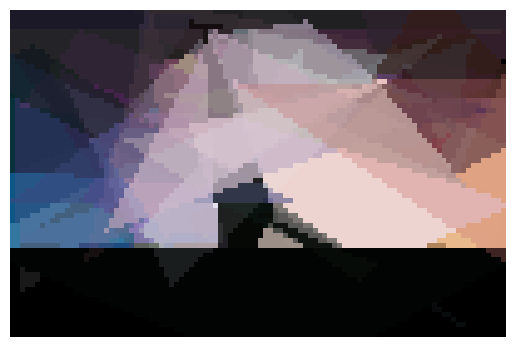

Fitness in Generation 2310: mean: -155.1860515186467, max: -155.08981161091887 min: -155.21728565936175
Fitness in Generation 2320: mean: -155.05325397923878, max: -154.99444828911956 min: -155.08482891195692
Fitness in Generation 2330: mean: -154.93927197231832, max: -154.8481045751634 min: -154.98146866589772
Fitness in Generation 2340: mean: -154.75630280661284, max: -154.67514033064205 min: -154.8092887351019
Fitness in Generation 2350: mean: -154.546062437524, max: -154.0318800461361 min: -154.66020761245673
Fitness in Generation 2360: mean: -153.77777808535183, max: -153.73204152249136 min: -153.88984236831988
Fitness in Generation 2370: mean: -153.62292733564013, max: -153.5051134179162 min: -153.66937331795464
Fitness in Generation 2380: mean: -153.24827327950788, max: -153.09436370626682 min: -153.3854517493272
Fitness in Generation 2390: mean: -152.95930765090347, max: -152.88855055747788 min: -153.00478277585543
Fitness in Generation 2400: mean: -152.66670634371394, max: -15

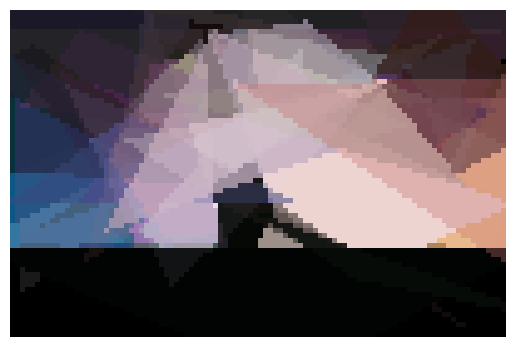

Fitness in Generation 2410: mean: -152.14579069588615, max: -150.48339869281045 min: -152.1929257977701
Fitness in Generation 2420: mean: -150.30589542483654, max: -150.1423298731257 min: -150.48339869281045
Fitness in Generation 2430: mean: -149.7983226451365, max: -149.58545174932718 min: -150.08272202998847
Fitness in Generation 2440: mean: -149.10617316416761, max: -148.99203383314108 min: -149.21922337562475
Fitness in Generation 2450: mean: -148.0775144944252, max: -148.01896193771623 min: -148.16350634371395
Fitness in Generation 2460: mean: -148.01068788927336, max: -147.9279046520569 min: -148.01896193771623
Fitness in Generation 2470: mean: -147.8056059976932, max: -147.72362937331795 min: -147.8860899653979
Fitness in Generation 2480: mean: -147.63564782775853, max: -147.55257208765858 min: -147.67747789311804
Fitness in Generation 2490: mean: -147.38542329873124, max: -147.1670280661284 min: -147.49914648212226
Fitness in Generation 2500: mean: -146.95107235678586, max: -14

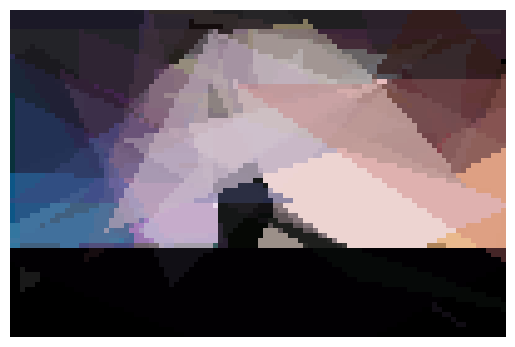

Fitness in Generation 2510: mean: -146.7006054594387, max: -146.07189542483658 min: -146.84104575163397
Fitness in Generation 2520: mean: -145.91334579008074, max: -145.7666743560169 min: -146.03257208765856
Fitness in Generation 2530: mean: -145.57425713187237, max: -145.55507881584006 min: -145.65499423298732
Fitness in Generation 2540: mean: -145.509230757401, max: -145.2796462898885 min: -145.5523106497501
Fitness in Generation 2550: mean: -145.13002798923492, max: -144.9600768935025 min: -145.15372549019608
Fitness in Generation 2560: mean: -144.91804183006536, max: -144.67358708189158 min: -144.9600768935025
Fitness in Generation 2570: mean: -144.5771203383314, max: -144.47600153787002 min: -144.67358708189158
Fitness in Generation 2580: mean: -144.34234878892732, max: -144.2141176470588 min: -144.47598615916954
Fitness in Generation 2590: mean: -144.13669188773548, max: -144.02257593233372 min: -144.21811610918877
Fitness in Generation 2600: mean: -143.98838185313343, max: -143.

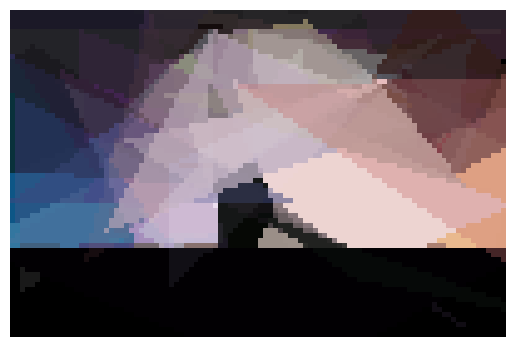

Fitness in Generation 2610: mean: -143.90049227220297, max: -143.8724029219531 min: -143.92936562860436
Fitness in Generation 2620: mean: -143.81033694732793, max: -143.60919646289886 min: -143.8723875432526
Fitness in Generation 2630: mean: -143.5164153787005, max: -143.24576701268742 min: -143.54025374855823
Fitness in Generation 2640: mean: -143.18852825836217, max: -143.11818531334103 min: -143.24576701268742
Fitness in Generation 2650: mean: -143.09905036524415, max: -143.02500576701266 min: -143.11590926566706
Fitness in Generation 2660: mean: -143.0078826605152, max: -142.86509803921567 min: -143.02500576701266
Fitness in Generation 2670: mean: -142.80881968473665, max: -142.71477124183005 min: -142.8641445597847
Fitness in Generation 2680: mean: -142.61803490965013, max: -142.5432833525567 min: -142.678892733564
Fitness in Generation 2690: mean: -142.50134040753557, max: -142.41662437524027 min: -142.5432833525567
Fitness in Generation 2700: mean: -142.19602399077277, max: -142

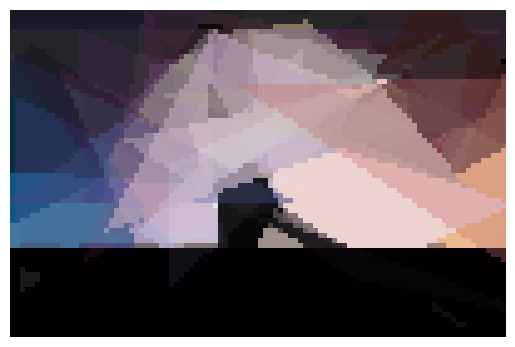

Fitness in Generation 2710: mean: -142.00667681660894, max: -141.98632833525568 min: -142.0382622068435
Fitness in Generation 2720: mean: -141.8844867358708, max: -141.8555017301038 min: -141.91744713571703
Fitness in Generation 2730: mean: -141.77817485582466, max: -141.74605151864665 min: -141.80910419069588
Fitness in Generation 2740: mean: -141.55133933102655, max: -141.48292195309497 min: -141.69379469434833
Fitness in Generation 2750: mean: -141.43937962322184, max: -141.3953248750481 min: -141.4577162629758
Fitness in Generation 2760: mean: -140.92918754325262, max: -140.5685351787774 min: -141.34952710495966
Fitness in Generation 2770: mean: -140.50330595924643, max: -139.87575547866206 min: -140.64736639753943
Fitness in Generation 2780: mean: -139.7009702422145, max: -139.42451364859667 min: -139.84999615532485
Fitness in Generation 2790: mean: -139.27752741253357, max: -139.0026912725875 min: -139.42376009227218
Fitness in Generation 2800: mean: -138.6436515186467, max: -138

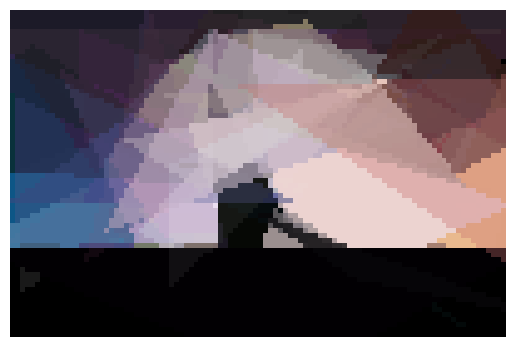

Fitness in Generation 2810: mean: -138.0697783929258, max: -137.65557862360632 min: -138.35787773933103
Fitness in Generation 2820: mean: -137.52744036908882, max: -136.86934256055363 min: -137.642276047674
Fitness in Generation 2830: mean: -136.72355909265667, max: -136.38652825836218 min: -136.86000768935025
Fitness in Generation 2840: mean: -136.22539315647828, max: -136.16453671664746 min: -136.32358323721647
Fitness in Generation 2850: mean: -136.0725871587851, max: -136.01022683583238 min: -136.0792772010765
Fitness in Generation 2860: mean: -135.96989311803156, max: -135.8314033064206 min: -136.01880815071127
Fitness in Generation 2870: mean: -135.71423498654363, max: -135.65279507881584 min: -135.76668973471743
Fitness in Generation 2880: mean: -135.63470772779695, max: -135.60287581699347 min: -135.65279507881584
Fitness in Generation 2890: mean: -135.5791549404076, max: -135.53125720876588 min: -135.60401384083045
Fitness in Generation 2900: mean: -135.49593971549405, max: -1

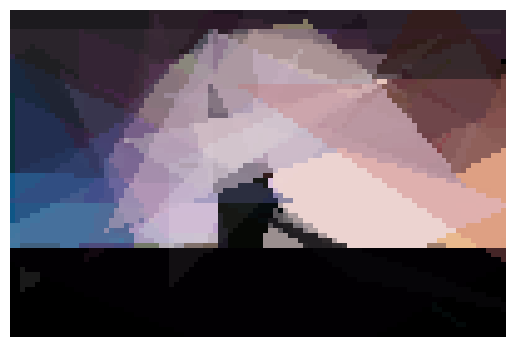

Fitness in Generation 2910: mean: -135.41811457131874, max: -135.29888504421376 min: -135.45451749327182
Fitness in Generation 2920: mean: -135.20188681276434, max: -135.00409073433295 min: -135.27354094579007
Fitness in Generation 2930: mean: -134.89781945405613, max: -134.3997078046905 min: -135.00149173394848
Fitness in Generation 2940: mean: -134.29089227220302, max: -134.23610918877355 min: -134.35118800461362
Fitness in Generation 2950: mean: -134.21091764705884, max: -133.17462514417534 min: -134.23610918877355
Fitness in Generation 2960: mean: -133.12231141868511, max: -133.06259131103423 min: -133.17462514417534
Fitness in Generation 2970: mean: -132.9827761630142, max: -132.90197616301424 min: -132.9927258746636
Fitness in Generation 2980: mean: -132.88317585544021, max: -132.84156862745098 min: -132.90197616301424
Fitness in Generation 2990: mean: -132.70177454825068, max: -132.63812379853903 min: -132.759569396386
Fitness in Generation 3000: mean: -132.61862852748945, max: 

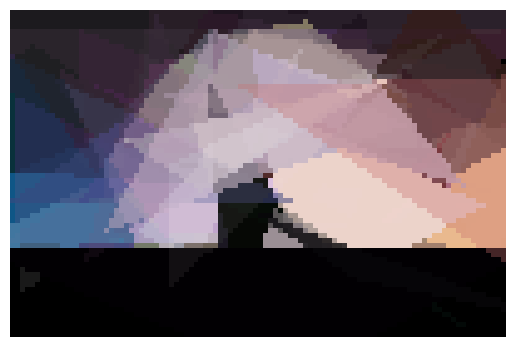

Fitness in Generation 3010: mean: -132.44962291426376, max: -132.35203383314112 min: -132.53750096116877
Fitness in Generation 3020: mean: -132.3411115724721, max: -132.26831218762015 min: -132.34503652441367
Fitness in Generation 3030: mean: -132.15781976163015, max: -132.03063437139562 min: -132.25953094963475
Fitness in Generation 3040: mean: -131.95961691657058, max: -131.83046520569013 min: -132.02812764321416
Fitness in Generation 3050: mean: -131.8165071895425, max: -131.77574778931182 min: -131.83046520569013
Fitness in Generation 3060: mean: -131.74455470972703, max: -131.64973471741638 min: -131.77574778931182
Fitness in Generation 3070: mean: -131.60539946174552, max: -131.53737793156478 min: -131.61886966551324
Fitness in Generation 3080: mean: -131.44794002306804, max: -131.35740099961552 min: -131.50941945405614
Fitness in Generation 3090: mean: -131.35733164167624, max: -131.3524029219531 min: -131.37176470588233
Fitness in Generation 3100: mean: -131.3192169165705, max:

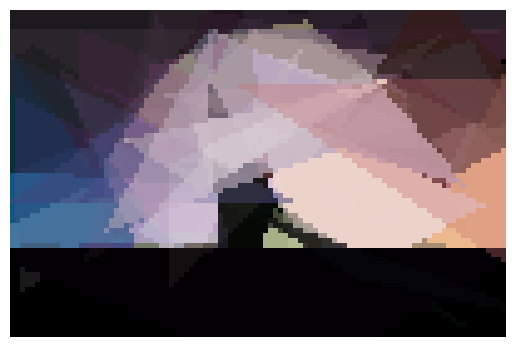

Fitness in Generation 3110: mean: -131.26016839677047, max: -131.24246059207996 min: -131.27623221837754
Fitness in Generation 3120: mean: -131.21523321799307, max: -131.17920799692425 min: -131.24246059207996
Fitness in Generation 3130: mean: -131.17568888888889, max: -131.0950096116878 min: -131.17920799692425
Fitness in Generation 3140: mean: -131.06937777777782, max: -130.9606612841215 min: -131.0950096116878
Fitness in Generation 3150: mean: -130.87597524029218, max: -130.60092272203 min: -130.9512648981161
Fitness in Generation 3160: mean: -130.35212502883505, max: -129.4938254517493 min: -130.78629757785467
Fitness in Generation 3170: mean: -129.41053963860054, max: -129.3605690119185 min: -129.4938254517493
Fitness in Generation 3180: mean: -129.2754289888504, max: -129.19647827758553 min: -129.3375163398693
Fitness in Generation 3190: mean: -129.1383672433679, max: -129.00951941560936 min: -129.17262591311032
Fitness in Generation 3200: mean: -128.9958129950019, max: -128.9571

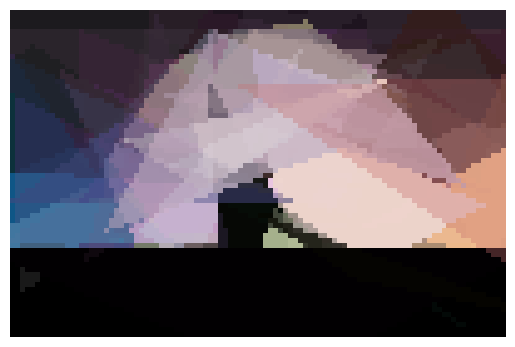

Fitness in Generation 3210: mean: -128.93383498654362, max: -128.8152864282968 min: -128.9571856978085
Fitness in Generation 3220: mean: -128.64884367550937, max: -128.44075355632447 min: -128.7650595924644
Fitness in Generation 3230: mean: -128.38920292195309, max: -128.21331795463283 min: -128.43633986928103
Fitness in Generation 3240: mean: -128.08246412918103, max: -127.84882737408688 min: -128.1101576316801
Fitness in Generation 3250: mean: -127.78948127643214, max: -127.74045367166472 min: -127.84882737408688
Fitness in Generation 3260: mean: -127.714524567474, max: -127.66723567858514 min: -127.74469819300266
Fitness in Generation 3270: mean: -127.61804152249132, max: -127.5912956555171 min: -127.64250672818146
Fitness in Generation 3280: mean: -127.54918554402151, max: -127.52370626682045 min: -127.57728565936176
Fitness in Generation 3290: mean: -127.4723980007689, max: -127.43207996924258 min: -127.51143406382161
Fitness in Generation 3300: mean: -127.27618577470203, max: -12

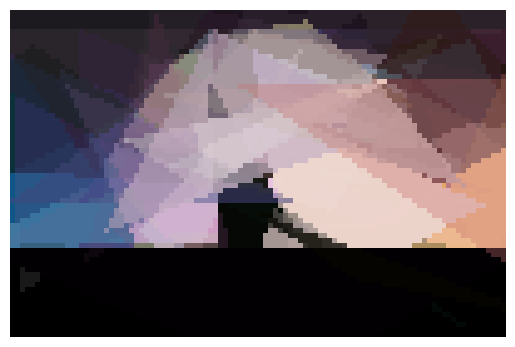

Fitness in Generation 3310: mean: -126.98495824682811, max: -126.82898885044213 min: -127.05385620915031
Fitness in Generation 3320: mean: -126.76856332179928, max: -126.45856209150325 min: -126.81891580161476
Fitness in Generation 3330: mean: -126.29690949634757, max: -126.2162860438293 min: -126.4164090734333
Fitness in Generation 3340: mean: -126.13022652825835, max: -126.07229527104958 min: -126.21505574778932
Fitness in Generation 3350: mean: -126.02920968858132, max: -125.94848135332565 min: -126.07037293348712
Fitness in Generation 3360: mean: -125.82092087658592, max: -125.65834678969628 min: -125.87620146097656
Fitness in Generation 3370: mean: -125.62550911188004, max: -125.50863514033063 min: -125.65834678969628
Fitness in Generation 3380: mean: -125.42704913494808, max: -125.31467896962704 min: -125.47855440215301
Fitness in Generation 3390: mean: -125.28241584006149, max: -125.23503267973855 min: -125.29034986543637
Fitness in Generation 3400: mean: -125.16975455594, max: 

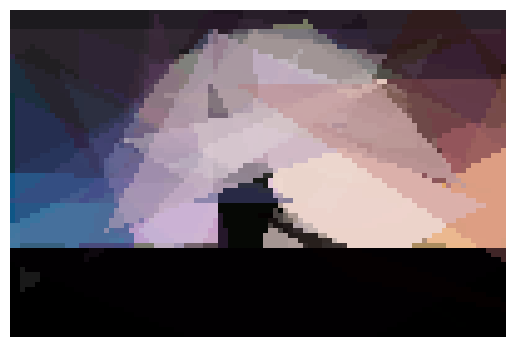

Fitness in Generation 3410: mean: -125.07374194540559, max: -125.01248750480583 min: -125.10039215686274
Fitness in Generation 3420: mean: -124.91356462898887, max: -124.63026528258362 min: -124.96425990003844
Fitness in Generation 3430: mean: -124.61096255286431, max: -124.52778162245288 min: -124.6391234140715
Fitness in Generation 3440: mean: -124.49299807766245, max: -124.47437139561707 min: -124.50912725874663
Fitness in Generation 3450: mean: -124.44032187620147, max: -124.40632064590544 min: -124.47437139561707
Fitness in Generation 3460: mean: -124.3085393310265, max: -124.29231833910033 min: -124.31215686274508
Fitness in Generation 3470: mean: -124.22170165321026, max: -124.19320261437908 min: -124.29231833910033
Fitness in Generation 3480: mean: -124.16635617070357, max: -124.12995001922337 min: -124.18356016916569
Fitness in Generation 3490: mean: -124.02127550941947, max: -123.72472126105343 min: -124.12995001922337
Fitness in Generation 3500: mean: -123.44767889273356, ma

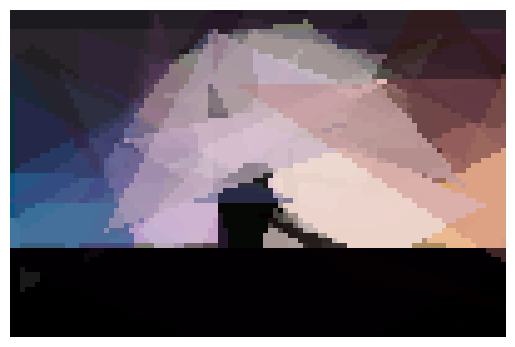

Fitness in Generation 3510: mean: -123.08015778546712, max: -123.02045367166474 min: -123.16450595924644
Fitness in Generation 3520: mean: -123.01704682814301, max: -123.01013456362936 min: -123.02045367166474
Fitness in Generation 3530: mean: -122.99145344098424, max: -122.96224529027297 min: -123.01570165321031
Fitness in Generation 3540: mean: -122.91447581699347, max: -122.66612841214916 min: -122.95594002306804
Fitness in Generation 3550: mean: -122.36351910803538, max: -122.02126874279124 min: -122.65284121491733
Fitness in Generation 3560: mean: -122.0024822760477, max: -121.94848135332565 min: -122.02126874279124
Fitness in Generation 3570: mean: -121.83716447520183, max: -121.73168781237983 min: -121.94742022299114
Fitness in Generation 3580: mean: -121.7176595155709, max: -121.70459054209918 min: -121.73090349865434
Fitness in Generation 3590: mean: -121.623908496732, max: -121.56642829680891 min: -121.67437139561706
Fitness in Generation 3600: mean: -121.54605382545176, max:

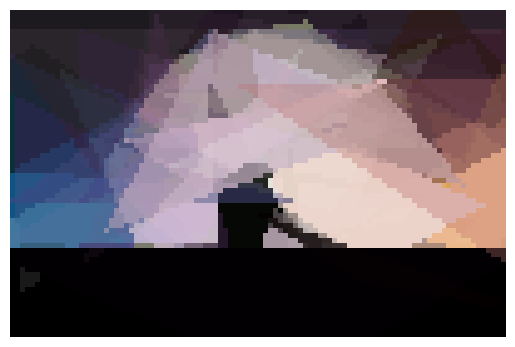

Fitness in Generation 3610: mean: -121.43227143406382, max: -121.41039600153786 min: -121.45936178392925
Fitness in Generation 3620: mean: -121.40220315263359, max: -121.35327950788157 min: -121.40738177623989
Fitness in Generation 3630: mean: -120.02698054594384, max: -119.74486735870819 min: -121.33571703191079
Fitness in Generation 3640: mean: -119.74352541330258, max: -119.72093810073046 min: -119.74486735870819
Fitness in Generation 3650: mean: -119.6917657823914, max: -119.67347943098807 min: -119.72093810073046
Fitness in Generation 3660: mean: -119.67177916186081, max: -119.65127258746635 min: -119.67347943098807
Fitness in Generation 3670: mean: -119.6492444444444, max: -119.64181468665898 min: -119.64931949250288
Fitness in Generation 3680: mean: -119.60112018454436, max: -119.57842368319875 min: -119.64181468665898
Fitness in Generation 3690: mean: -119.4427294117647, max: -118.92169165705496 min: -119.57842368319875
Fitness in Generation 3700: mean: -118.9077270280661, max:

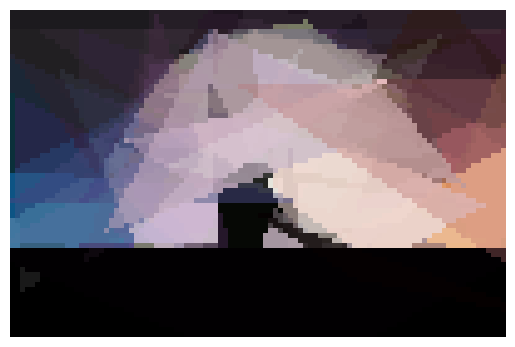

Fitness in Generation 3710: mean: -117.05766797385621, max: -116.93399461745483 min: -118.50998846597463
Fitness in Generation 3720: mean: -116.91355217224141, max: -116.8724029219531 min: -116.94074586697424
Fitness in Generation 3730: mean: -116.7829444059977, max: -116.75427912341407 min: -116.8724029219531
Fitness in Generation 3740: mean: -116.73525382545176, max: -116.69748558246827 min: -116.75234140715108
Fitness in Generation 3750: mean: -116.68390203767781, max: -116.65687043444828 min: -116.69748558246827
Fitness in Generation 3760: mean: -116.47407889273357, max: -116.40070742022299 min: -116.62031526336024
Fitness in Generation 3770: mean: -116.18028266051519, max: -116.07347943098809 min: -116.38715878508266
Fitness in Generation 3780: mean: -115.99899346405229, max: -115.83709342560554 min: -116.07046520569011
Fitness in Generation 3790: mean: -115.8120504421376, max: -115.73943867743176 min: -115.83709342560554
Fitness in Generation 3800: mean: -115.70964628988848, max:

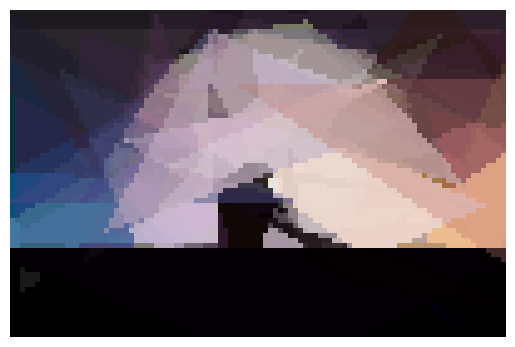

Fitness in Generation 3810: mean: -115.5792244521338, max: -115.54934256055364 min: -115.60150711264899
Fitness in Generation 3820: mean: -115.50945836216837, max: -115.45923875432526 min: -115.54775855440217
Fitness in Generation 3830: mean: -115.3933774702038, max: -115.34300653594771 min: -115.45460976547481
Fitness in Generation 3840: mean: -115.31149680891966, max: -115.29194925028834 min: -115.34300653594771
Fitness in Generation 3850: mean: -115.2429141099577, max: -115.18841983852364 min: -115.2875816993464
Fitness in Generation 3860: mean: -115.1604433679354, max: -114.5913417916186 min: -115.18841983852364
Fitness in Generation 3870: mean: -114.55563537101116, max: -114.50243752402922 min: -114.59678585159554
Fitness in Generation 3880: mean: -114.39089519415612, max: -114.36039984621299 min: -114.50243752402922
Fitness in Generation 3890: mean: -114.3444469050365, max: -114.32150711264897 min: -114.36039984621299
Fitness in Generation 3900: mean: -114.3114834294502, max: -11

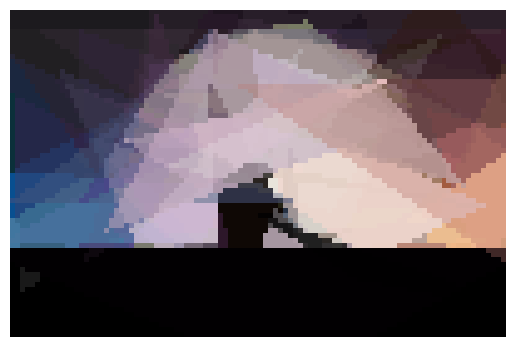

Fitness in Generation 3910: mean: -114.17452010765089, max: -114.1102499038831 min: -114.22929642445212
Fitness in Generation 3920: mean: -114.01250026912724, max: -113.97767012687427 min: -114.09079584775085
Fitness in Generation 3930: mean: -113.95770795847753, max: -113.92902729719339 min: -113.97767012687427
Fitness in Generation 3940: mean: -113.87603275663209, max: -113.78505190311418 min: -113.89760861207226
Fitness in Generation 3950: mean: -113.30192741253363, max: -113.12911956939637 min: -113.34642060745865
Fitness in Generation 3960: mean: -113.09042829680891, max: -112.96150711264896 min: -113.09204152249133
Fitness in Generation 3970: mean: -112.94955801614759, max: -112.81862360630525 min: -112.96150711264896
Fitness in Generation 3980: mean: -112.80152772010766, max: -112.79586312956555 min: -112.8072741253364
Fitness in Generation 3990: mean: -112.76313002691269, max: -112.69294886582082 min: -112.79586312956555
Fitness in Generation 4000: mean: -112.62873956170705, ma

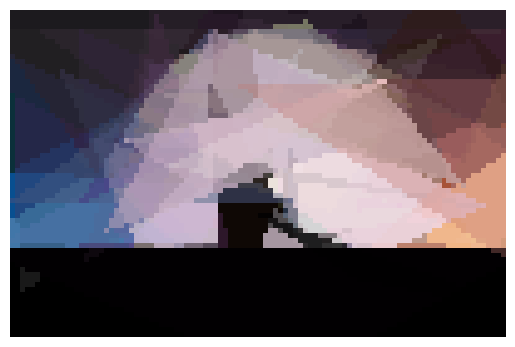

Fitness in Generation 4010: mean: -112.44904759707808, max: -112.43769319492502 min: -112.4638677431757
Fitness in Generation 4020: mean: -112.36507958477506, max: -112.35267973856207 min: -112.36905805459439
Fitness in Generation 4030: mean: -112.3344536716647, max: -112.27815455594 min: -112.35017301038062
Fitness in Generation 4040: mean: -112.26457946943479, max: -112.16758169934639 min: -112.27815455594
Fitness in Generation 4050: mean: -112.1399838523645, max: -112.01468665897731 min: -112.16507497116494
Fitness in Generation 4060: mean: -111.98404029219529, max: -111.97122645136486 min: -111.98911188004612
Fitness in Generation 4070: mean: -111.96582360630528, max: -111.87590926566703 min: -111.97122645136486
Fitness in Generation 4080: mean: -111.86830957324106, max: -111.760830449827 min: -111.87255670895807
Fitness in Generation 4090: mean: -111.7513471741638, max: -111.7351018838908 min: -111.75832372164552
Fitness in Generation 4100: mean: -111.71948788927335, max: -111.706

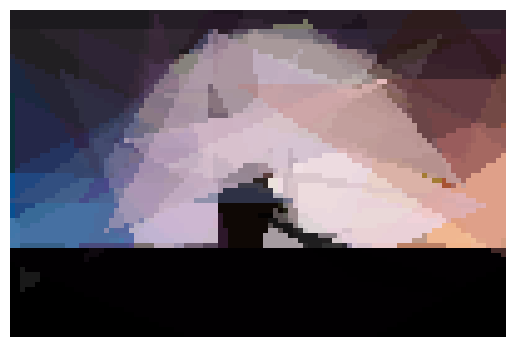

Fitness in Generation 4110: mean: -111.65397293348707, max: -111.42986543637063 min: -111.70254517493272
Fitness in Generation 4120: mean: -111.31430742022296, max: -111.11363321799307 min: -111.36436755094194
Fitness in Generation 4130: mean: -110.66715816993462, max: -110.01757785467127 min: -110.90631295655517
Fitness in Generation 4140: mean: -110.00955878508263, max: -110.00798154555939 min: -110.01294886582083
Fitness in Generation 4150: mean: -109.82554294502116, max: -109.72831987697039 min: -110.00798154555939
Fitness in Generation 4160: mean: -109.69439338715881, max: -109.69145713187235 min: -109.70026912725875
Fitness in Generation 4170: mean: -109.60738715878506, max: -109.52221453287197 min: -109.69145713187235
Fitness in Generation 4180: mean: -109.51448258362164, max: -109.47594002306805 min: -109.52101499423298
Fitness in Generation 4190: mean: -109.47566366782009, max: -109.47001922337562 min: -109.47594002306805
Fitness in Generation 4200: mean: -109.4059869281046, m

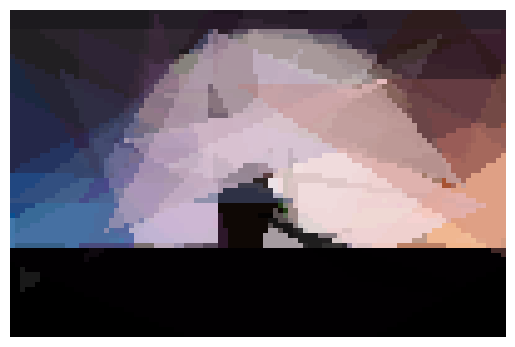

Fitness in Generation 4210: mean: -109.35056870434448, max: -109.18494425221068 min: -109.37527104959632
Fitness in Generation 4220: mean: -109.1512166089965, max: -109.10486735870818 min: -109.18209919261822
Fitness in Generation 4230: mean: -109.07504083044984, max: -109.03367935409457 min: -109.10486735870818
Fitness in Generation 4240: mean: -109.01224359861594, max: -108.99764705882353 min: -109.02780469050364
Fitness in Generation 4250: mean: -108.9566948096886, max: -108.9441291810842 min: -108.99148019992312
Fitness in Generation 4260: mean: -108.93603260284505, max: -108.92779700115341 min: -108.9441291810842
Fitness in Generation 4270: mean: -108.90627958477508, max: -108.87061899269511 min: -108.9204459823145
Fitness in Generation 4280: mean: -108.85781314878892, max: -108.77277970011534 min: -108.87061899269511
Fitness in Generation 4290: mean: -108.68387512495194, max: -108.63295655517108 min: -108.76236831987697
Fitness in Generation 4300: mean: -108.62438462129947, max: 

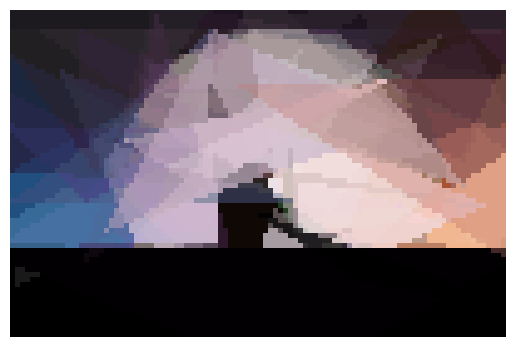

Fitness in Generation 4310: mean: -108.5748244521338, max: -108.5365013456363 min: -108.58808150711265
Fitness in Generation 4320: mean: -108.50632187620151, max: -108.41616301422529 min: -108.51970780469051
Fitness in Generation 4330: mean: -108.39446981930028, max: -108.320153787005 min: -108.41616301422529
Fitness in Generation 4340: mean: -108.29538638985002, max: -108.25244136870434 min: -108.320153787005
Fitness in Generation 4350: mean: -108.10594109957702, max: -107.999876970396 min: -108.25244136870434
Fitness in Generation 4360: mean: -107.9722522106882, max: -107.8797693194925 min: -107.999876970396
Fitness in Generation 4370: mean: -107.851538792772, max: -107.75095732410611 min: -107.88561322568243
Fitness in Generation 4380: mean: -107.7033464052288, max: -107.600246059208 min: -107.72209150326798
Fitness in Generation 4390: mean: -107.56824667435602, max: -107.55023452518263 min: -107.57034986543637
Fitness in Generation 4400: mean: -107.54367212610533, max: -107.5171241

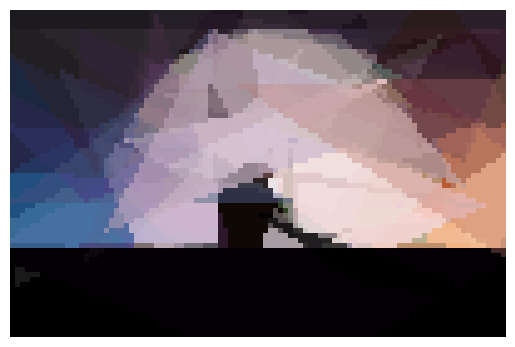

Fitness in Generation 4410: mean: -107.50887827758555, max: -107.4872126105344 min: -107.52447520184545
Fitness in Generation 4420: mean: -107.47931380238371, max: -107.38632833525567 min: -107.4872126105344
Fitness in Generation 4430: mean: -107.3634063821607, max: -107.35341791618609 min: -107.37339484813533
Fitness in Generation 4440: mean: -107.34620838139178, max: -107.33027297193388 min: -107.35341791618609
Fitness in Generation 4450: mean: -107.32341038062287, max: -107.31223375624761 min: -107.33027297193388
Fitness in Generation 4460: mean: -107.2901414840446, max: -107.24808919646289 min: -107.30339100346019
Fitness in Generation 4470: mean: -107.23812564398304, max: -107.22020761245675 min: -107.24808919646289
Fitness in Generation 4480: mean: -107.20829696270661, max: -107.1919261822376 min: -107.22020761245675
Fitness in Generation 4490: mean: -107.18202629757786, max: -107.17700884275278 min: -107.18774317570164
Fitness in Generation 4500: mean: -107.16478692810456, max: 

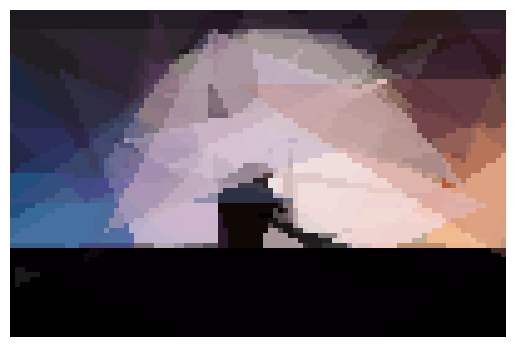

Fitness in Generation 4510: mean: -107.13129227220301, max: -107.05241061130333 min: -107.13946943483275
Fitness in Generation 4520: mean: -107.03382360630526, max: -107.00435217224144 min: -107.03766243752403
Fitness in Generation 4530: mean: -106.98324982698963, max: -106.87575547866204 min: -107.00435217224144
Fitness in Generation 4540: mean: -106.86849888504425, max: -106.84773548635138 min: -106.87575547866204
Fitness in Generation 4550: mean: -106.84005567089582, max: -106.8305882352941 min: -106.84773548635138
Fitness in Generation 4560: mean: -106.8291856978085, max: -106.78900422914262 min: -106.8305882352941
Fitness in Generation 4570: mean: -106.78900422914259, max: -106.78900422914262 min: -106.78900422914262
Fitness in Generation 4580: mean: -106.78686797385618, max: -106.78585159554017 min: -106.78900422914262
Fitness in Generation 4590: mean: -106.7856596693579, max: -106.78105344098422 min: -106.78585159554017
Fitness in Generation 4600: mean: -106.78105344098418, max:

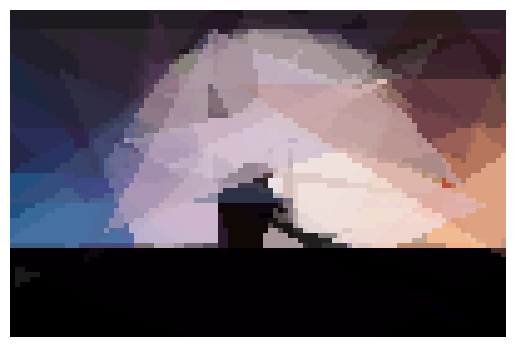

Fitness in Generation 4610: mean: -106.7729877739331, max: -106.71964628988849 min: -106.78105344098422
Fitness in Generation 4620: mean: -106.71217900807378, max: -106.7038523644752 min: -106.71964628988849
Fitness in Generation 4630: mean: -106.70199984621297, max: -106.69436370626681 min: -106.7038523644752
Fitness in Generation 4640: mean: -106.68996862745097, max: -106.6632833525567 min: -106.69436370626681
Fitness in Generation 4650: mean: -106.64899177239522, max: -106.62694348327565 min: -106.66068435217223
Fitness in Generation 4660: mean: -106.57537424067667, max: -106.42006920415224 min: -106.62665128796615
Fitness in Generation 4670: mean: -106.41221683967706, max: -106.38520569011918 min: -106.41617839292579
Fitness in Generation 4680: mean: -106.35749634755861, max: -106.28244521337948 min: -106.37216455209534
Fitness in Generation 4690: mean: -106.24806612841213, max: -106.12181468665898 min: -106.26228373702423
Fitness in Generation 4700: mean: -106.0791123414072, max: 

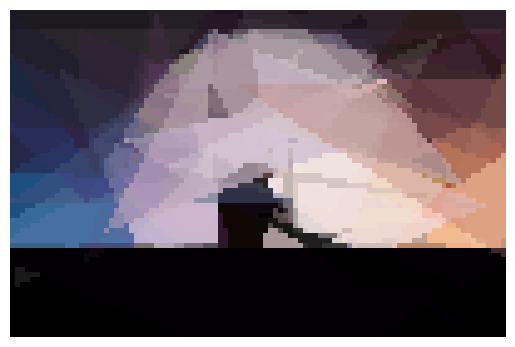

Fitness in Generation 4710: mean: -105.61593248750474, max: -105.56590542099192 min: -105.6479661668589
Fitness in Generation 4720: mean: -105.55581176470585, max: -105.44632064590542 min: -105.61328719723183
Fitness in Generation 4730: mean: -105.42815117262595, max: -105.27006535947712 min: -105.44632064590542
Fitness in Generation 4740: mean: -105.25255978469815, max: -105.21527104959631 min: -105.27006535947712
Fitness in Generation 4750: mean: -105.19478369857747, max: -105.14771241830064 min: -105.21527104959631
Fitness in Generation 4760: mean: -105.01558708189155, max: -104.96495194156091 min: -105.10483660130717
Fitness in Generation 4770: mean: -104.95978762014609, max: -104.92156862745097 min: -104.96495194156091
Fitness in Generation 4780: mean: -104.91991049596308, max: -104.89645520953479 min: -104.92156862745097
Fitness in Generation 4790: mean: -104.8852349096501, max: -104.86994232987311 min: -104.8873817762399
Fitness in Generation 4800: mean: -104.82473079584776, max

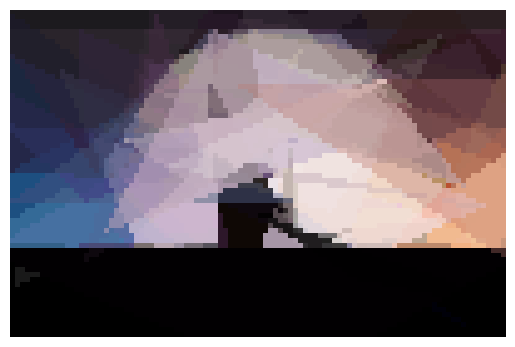

Fitness in Generation 4810: mean: -104.68365367166473, max: -104.34620530565167 min: -104.77697808535177
Fitness in Generation 4820: mean: -104.34545497885425, max: -104.3423913879277 min: -104.34554402153017
Fitness in Generation 4830: mean: -104.3352607458669, max: -104.32496732026142 min: -104.3423913879277
Fitness in Generation 4840: mean: -104.32496593617837, max: -104.32492118415993 min: -104.32496732026142
Fitness in Generation 4850: mean: -104.30040215301803, max: -104.17893118031526 min: -104.32492118415993
Fitness in Generation 4860: mean: -104.17461637831602, max: -104.1435755478662 min: -104.17893118031526
Fitness in Generation 4870: mean: -104.12018162245288, max: -104.01068819684735 min: -104.13802383698577
Fitness in Generation 4880: mean: -103.96173502499038, max: -103.94685121107267 min: -103.98929642445214
Fitness in Generation 4890: mean: -103.94638908112267, max: -103.94292964244521 min: -103.94777393310265
Fitness in Generation 4900: mean: -103.9428358323722, max: 

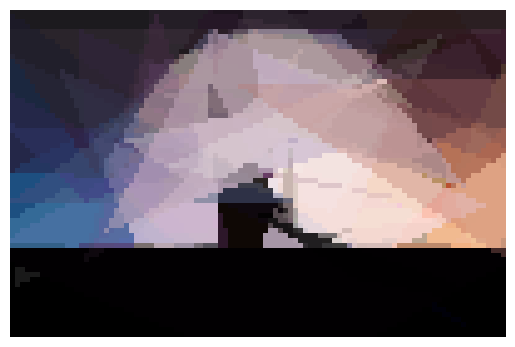

Fitness in Generation 4910: mean: -103.93482722029985, max: -103.90912725874662 min: -103.9426066897347
Fitness in Generation 4920: mean: -103.87276693579395, max: -103.86136101499423 min: -103.88186082276047
Fitness in Generation 4930: mean: -103.85857116493656, max: -103.85685505574777 min: -103.86156093810072
Fitness in Generation 4940: mean: -103.84977193387157, max: -103.82445213379468 min: -103.85616301422529
Fitness in Generation 4950: mean: -103.81475063437138, max: -103.80750480584389 min: -103.82445213379468
Fitness in Generation 4960: mean: -103.80551726259128, max: -103.79615532487504 min: -103.80750480584389
Fitness in Generation 4970: mean: -103.77621284121491, max: -103.74595924644366 min: -103.79615532487504
Fitness in Generation 4980: mean: -103.70032249134948, max: -103.65387158785082 min: -103.7124183006536
Fitness in Generation 4990: mean: -103.63680707420222, max: -103.60170703575547 min: -103.65387158785082
Fitness in Generation 5000: mean: -103.5918479046521, max

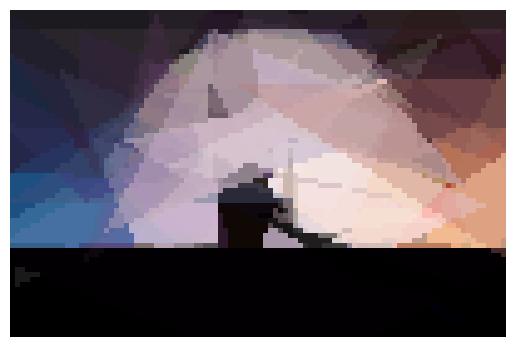

Fitness in Generation 5010: mean: -103.42043829296425, max: -103.38794309880814 min: -103.42193002691272
Fitness in Generation 5020: mean: -103.38078692810461, max: -103.37414840445982 min: -103.38794309880814
Fitness in Generation 5030: mean: -103.35019346405228, max: -103.32438292964244 min: -103.36518262206842
Fitness in Generation 5040: mean: -103.27246212995004, max: -103.15450980392156 min: -103.32438292964244
Fitness in Generation 5050: mean: -103.13006228373702, max: -103.10016147635524 min: -103.15450980392156
Fitness in Generation 5060: mean: -103.09344744329104, max: -103.06408304498268 min: -103.10016147635524
Fitness in Generation 5070: mean: -103.04713433294889, max: -103.039938485198 min: -103.06140715109572
Fitness in Generation 5080: mean: -103.03748235294111, max: -103.03264898116109 min: -103.039938485198
Fitness in Generation 5090: mean: -103.00284752018457, max: -102.97010380622837 min: -103.03586312956554
Fitness in Generation 5100: mean: -102.96530057670127, max:

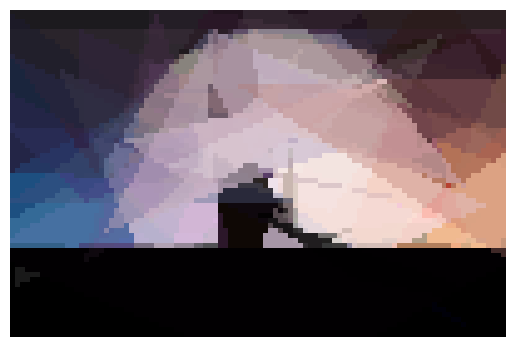

Fitness in Generation 5110: mean: -102.93316124567471, max: -102.90606689734716 min: -102.95541714725104
Fitness in Generation 5120: mean: -102.8749188773549, max: -102.86497500961167 min: -102.88801230296039
Fitness in Generation 5130: mean: -102.85542637447134, max: -102.82854286812764 min: -102.85863898500574
Fitness in Generation 5140: mean: -102.80702668204536, max: -102.79655517108804 min: -102.82603613994617
Fitness in Generation 5150: mean: -102.79373087274124, max: -102.79063437139561 min: -102.79655517108804
Fitness in Generation 5160: mean: -102.7779572472126, max: -102.76513648596692 min: -102.7905728565936
Fitness in Generation 5170: mean: -102.69004444444442, max: -102.30920415224912 min: -102.76058439061899
Fitness in Generation 5180: mean: -102.2958000768935, max: -102.26835832372164 min: -102.3036678200692
Fitness in Generation 5190: mean: -102.25789680891965, max: -102.22881968473664 min: -102.26835832372164
Fitness in Generation 5200: mean: -102.21791895424836, max: 

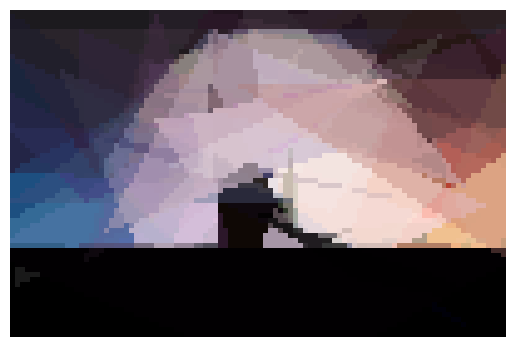

Fitness in Generation 5210: mean: -102.18456808919647, max: -102.12066128412148 min: -102.19546328335255
Fitness in Generation 5220: mean: -102.11308189158015, max: -102.10016147635523 min: -102.12066128412148
Fitness in Generation 5230: mean: -102.08893071895429, max: -102.08104575163398 min: -102.09188773548635
Fitness in Generation 5240: mean: -102.06844982698959, max: -102.04407535563244 min: -102.0782622068435
Fitness in Generation 5250: mean: -101.86120845828526, max: -101.75615532487504 min: -102.04898116109189
Fitness in Generation 5260: mean: -101.74222868127639, max: -101.70394463667819 min: -101.75615532487504
Fitness in Generation 5270: mean: -101.69520076893501, max: -101.65776239907727 min: -101.70394463667819
Fitness in Generation 5280: mean: -101.63626958861977, max: -101.58965013456361 min: -101.65776239907727
Fitness in Generation 5290: mean: -101.5691544790465, max: -101.31303344867358 min: -101.58965013456361
Fitness in Generation 5300: mean: -101.25718108419835, ma

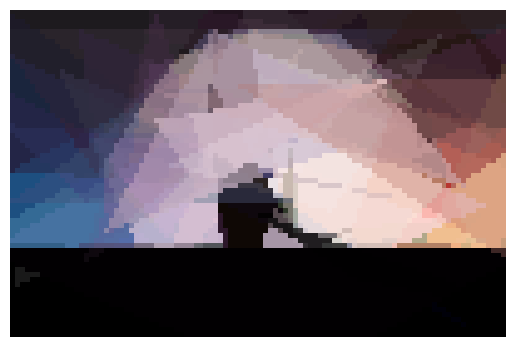

Fitness in Generation 5310: mean: -101.22625990003846, max: -101.1908035371011 min: -101.23641676278353
Fitness in Generation 5320: mean: -101.17472326028452, max: -101.14762014609765 min: -101.1908035371011
Fitness in Generation 5330: mean: -101.11086858900418, max: -101.06046905036524 min: -101.14860438292965
Fitness in Generation 5340: mean: -101.057599384852, max: -101.0549942329873 min: -101.05767012687429
Fitness in Generation 5350: mean: -101.03333687043443, max: -100.96884275278738 min: -101.0549942329873
Fitness in Generation 5360: mean: -100.93873433294884, max: -100.9262745098039 min: -100.9438369857747
Fitness in Generation 5370: mean: -100.90780299884658, max: -100.87833910034601 min: -100.92610534409843
Fitness in Generation 5380: mean: -100.86609457900802, max: -100.84891964628987 min: -100.87206459054208
Fitness in Generation 5390: mean: -100.73877447135716, max: -100.67824682814302 min: -100.84087658592848
Fitness in Generation 5400: mean: -100.63449796232217, max: -10

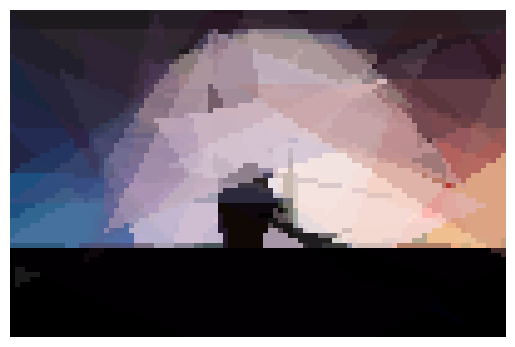

Fitness in Generation 5410: mean: -100.4450729719339, max: -100.399200307574 min: -100.48530565167242
Fitness in Generation 5420: mean: -100.3906128412149, max: -100.35758554402152 min: -100.39832372164551
Fitness in Generation 5430: mean: -100.33855363321801, max: -100.32839677047288 min: -100.34166858900423
Fitness in Generation 5440: mean: -100.32211995386388, max: -100.2957016532103 min: -100.33131872356786
Fitness in Generation 5450: mean: -100.27280353710111, max: -100.21324106113033 min: -100.3108035371011
Fitness in Generation 5460: mean: -100.20633833141099, max: -100.18660515186467 min: -100.21324106113033
Fitness in Generation 5470: mean: -100.13016855055749, max: -100.11526336024605 min: -100.1755632449058
Fitness in Generation 5480: mean: -100.1127164936563, max: -100.08123029603998 min: -100.11526336024605
Fitness in Generation 5490: mean: -100.07791880046138, max: -100.07281814686658 min: -100.08123029603998
Fitness in Generation 5500: mean: -100.07011780084581, max: -10

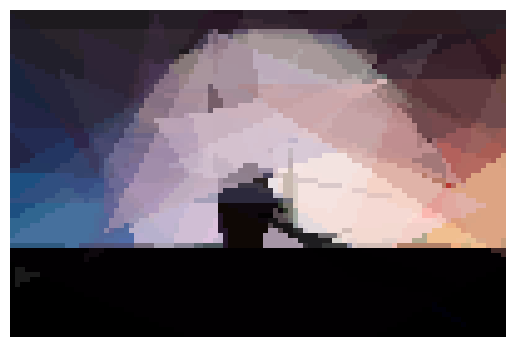

Fitness in Generation 5510: mean: -100.0412070742022, max: -100.01368704344483 min: -100.05333333333333
Fitness in Generation 5520: mean: -100.00176009227216, max: -99.95803152633601 min: -100.00858131487888
Fitness in Generation 5530: mean: -99.94501114955789, max: -99.94325259515571 min: -99.95247981545558
Fitness in Generation 5540: mean: -99.94111341791618, max: -99.93198000768935 min: -99.94325259515571
Fitness in Generation 5550: mean: -99.918462745098, max: -99.82229911572472 min: -99.93153402537484
Fitness in Generation 5560: mean: -99.80025313341022, max: -99.75072664359861 min: -99.80853517877738
Fitness in Generation 5570: mean: -99.7502585159554, max: -99.72569011918492 min: -99.75072664359861
Fitness in Generation 5580: mean: -99.72062145328718, max: -99.70754325259514 min: -99.74472895040367
Fitness in Generation 5590: mean: -99.70658900422906, max: -99.7027758554402 min: -99.70754325259514
Fitness in Generation 5600: mean: -99.69208673587083, max: -99.68755094194539 min:

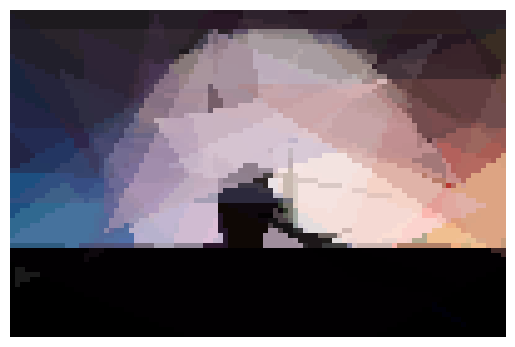

Fitness in Generation 5610: mean: -99.6856429065744, max: -99.68081507112649 min: -99.68755094194539
Fitness in Generation 5620: mean: -99.67753940792, max: -99.67753940792002 min: -99.67753940792002
Fitness in Generation 5630: mean: -99.6530566705113, max: -99.5659976931949 min: -99.67753940792002
Fitness in Generation 5640: mean: -99.55788435217224, max: -99.54712802768165 min: -99.5659976931949
Fitness in Generation 5650: mean: -99.51901853133411, max: -99.4725105728566 min: -99.53422529796231
Fitness in Generation 5660: mean: -99.47121030372934, max: -99.46329873125721 min: -99.4725105728566
Fitness in Generation 5670: mean: -99.45323644752021, max: -99.43578623606305 min: -99.46329873125721
Fitness in Generation 5680: mean: -99.42164767397153, max: -99.40564398308341 min: -99.43578623606305
Fitness in Generation 5690: mean: -99.40497962322185, max: -99.40379853902346 min: -99.40564398308341
Fitness in Generation 5700: mean: -99.36696163014227, max: -99.24449058054593 min: -99.4037

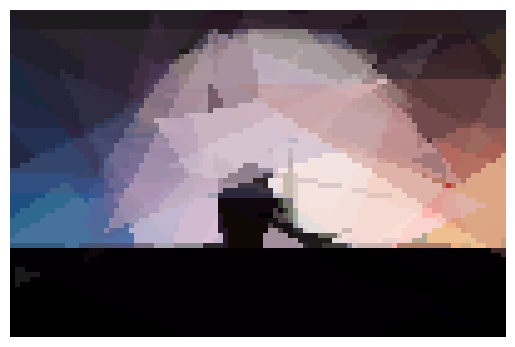

Fitness in Generation 5710: mean: -99.22782714340639, max: -99.20804306036138 min: -99.24449058054593
Fitness in Generation 5720: mean: -99.19327274125337, max: -99.16948865820838 min: -99.20509034986543
Fitness in Generation 5730: mean: -99.16001830065359, max: -99.1512341407151 min: -99.16828911956938
Fitness in Generation 5740: mean: -99.13968935024992, max: -99.13771626297577 min: -99.14820453671665
Fitness in Generation 5750: mean: -99.10541437908499, max: -99.08158400615147 min: -99.13771626297577
Fitness in Generation 5760: mean: -99.06080845828527, max: -99.02805074971164 min: -99.08158400615147
Fitness in Generation 5770: mean: -99.0145820838139, max: -98.95638600538256 min: -99.01734717416377
Fitness in Generation 5780: mean: -98.92146605151868, max: -98.83464821222607 min: -98.9837293348712
Fitness in Generation 5790: mean: -98.81931887735489, max: -98.80836601307189 min: -98.83464821222607
Fitness in Generation 5800: mean: -98.80203583237217, max: -98.70917339484814 min: -9

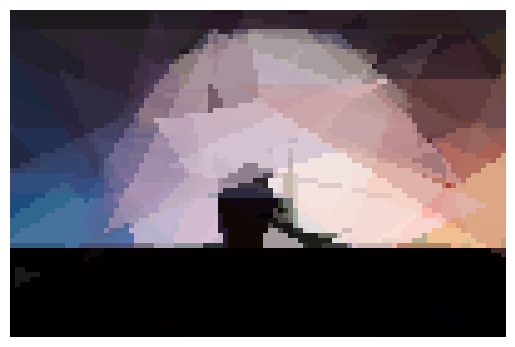

Fitness in Generation 5810: mean: -98.6992367550942, max: -98.42946559015762 min: -98.72264513648595
Fitness in Generation 5820: mean: -98.40356339869284, max: -98.38282199154172 min: -98.41776239907726
Fitness in Generation 5830: mean: -98.36113633217992, max: -98.29093425605535 min: -98.39786236063051
Fitness in Generation 5840: mean: -98.2888833525567, max: -98.28244521337946 min: -98.29185697808533
Fitness in Generation 5850: mean: -98.26657362552868, max: -98.25782391387926 min: -98.27603229527104
Fitness in Generation 5860: mean: -98.24620438292958, max: -98.21837754709726 min: -98.25782391387926
Fitness in Generation 5870: mean: -98.19910603613992, max: -98.19446366782006 min: -98.21837754709726
Fitness in Generation 5880: mean: -98.18415455594, max: -98.16853517877739 min: -98.19486351403306
Fitness in Generation 5890: mean: -98.1395332564398, max: -98.10500576701268 min: -98.16813533256438
Fitness in Generation 5900: mean: -98.08613917723953, max: -98.04919646289888 min: -98.1

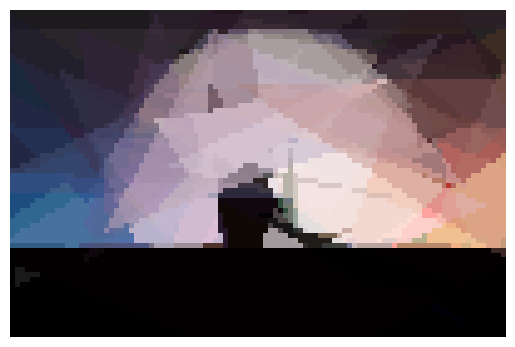

Fitness in Generation 5910: mean: -97.9784775086505, max: -97.96675124951939 min: -98.04919646289888


In [ ]:
target_image_path = r"C:\Users\Asus\Desktop\moon.jpg"
image = Image.open(target_image_path)
# Use resize to resize your images
image = resize(image,100)

width,height = image.size
population_size = 100
triangles_number = 50
alg = GeneticAlgorithm(width,height,image, population_size,triangles_number)
alg.run(10000)